Léa ZADIKIAN - Novembre 2022

# Projet n°4 : Anticipez les besoins en consommation de bâtiments
# Notebook exploratoire

Données et définition des variables : https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy

**Objectif** : prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l’habitation de la ville de Seattle, pour lesquels elles n’ont pas encore été mesurées.

# Sommaire :
<a href="#C1">1. Importation des données</a>


<a href="#C2">2. Nettoyage des données</a>

     2.1 Selection des bâtiments non destinés à l'habitation
     2.2 Recherche de doublons
     2.3 Traitement des outliers
     2.4 Supression des bâtiments avec valeurs de conso ou d'emission négatives
     2.5 Nettoyage des modalités de la variable 'Neighborhood'
    
<a href="#C3">3. Analyse exploratoire</a>

     3.1 Analyse univariée
     3.2 Analyse bivariée


<a href="#C4">4. Feature engineering - Première itération </a>

    4.1 Transformation logarithmique
    4.2 Binning de Années de construction du bâtiment
    4.3 Encodage des variables catégorielles avec OneHotEncoder()
  
<a href="#C5">5. Feature engineering - Deuxième itération</a>

     Encodage des usages des bâtiments avec importance de l'usage par rapport à la surface totale
     
<a href="#C6">6. Feature engineering - Troisième itération </a>

     Intérêt de EnergyStarScore


# <a name="C1">1. Importation des données</a>

In [1]:
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.preprocessing as preprocessing
from sklearn.preprocessing import OneHotEncoder

from sklearn import model_selection
from sklearn.dummy import DummyRegressor
from sklearn import metrics
from sklearn import linear_model
from sklearn import kernel_ridge

In [2]:
#Lecture et affichage du fichier '2016_Building_Energy_Benchmarking.csv'
data=pd.read_csv('2016_Building_Energy_Benchmarking.csv')
data

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3.946027e+06,12764.529300,1.276453e+06,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3.242851e+06,51450.816410,5.145082e+06,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,4.952666e+07,14938.000000,1.493800e+06,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2.768924e+06,18112.130860,1.811213e+06,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5.368607e+06,88039.984380,8.803998e+06,False,NaN,Compliant,NaN,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,50222,2016,Nonresidential COS,Office,Horticulture building,1600 S Dakota St,Seattle,WA,NaN,1624049080,...,1.536550e+05,5.242709e+05,3254.750244,3.254750e+05,True,NaN,Error - Correct Default Data,NaN,20.94,1.70
3372,50223,2016,Nonresidential COS,Other,International district/Chinatown CC,719 8th Ave S,Seattle,WA,NaN,3558300000,...,1.162210e+05,3.965461e+05,5537.299805,5.537300e+05,False,NaN,Compliant,NaN,32.17,2.01
3373,50224,2016,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,Seattle,WA,NaN,1794501150,...,5.252517e+05,1.792159e+06,39737.390630,3.973739e+06,False,NaN,Compliant,NaN,223.54,16.99
3374,50225,2016,Nonresidential COS,Mixed Use Property,South Park Community Center,8319 8th Ave S,Seattle,WA,NaN,7883603155,...,1.022480e+05,3.488702e+05,3706.010010,3.706010e+05,False,NaN,Compliant,NaN,22.11,1.57


Le jeu de données comporte :

    - 3.376 lignes, chaque ligne est un bâtiment.
    - 46 colonnes comportant les informations sur les bâtiments telles que : 
        - Localisation du bâtiment : adresse, quartier, coordonnées…
        - Caractéristiques du bâtiments : Année de construction, nb d’étages, surface, nombre de bâtiments etc…
        - Les différents usages du bâtiments et la surface associée (bureau, supermarché, hôpital,  hôtel, restaurant, parking etc…)

In [3]:
#Affichage du type des données
data.dtypes

OSEBuildingID                        int64
DataYear                             int64
BuildingType                        object
PrimaryPropertyType                 object
PropertyName                        object
Address                             object
City                                object
State                               object
ZipCode                            float64
TaxParcelIdentificationNumber       object
CouncilDistrictCode                  int64
Neighborhood                        object
Latitude                           float64
Longitude                          float64
YearBuilt                            int64
NumberofBuildings                  float64
NumberofFloors                       int64
PropertyGFATotal                     int64
PropertyGFAParking                   int64
PropertyGFABuilding(s)               int64
ListOfAllPropertyUseTypes           object
LargestPropertyUseType              object
LargestPropertyUseTypeGFA          float64
SecondLarge

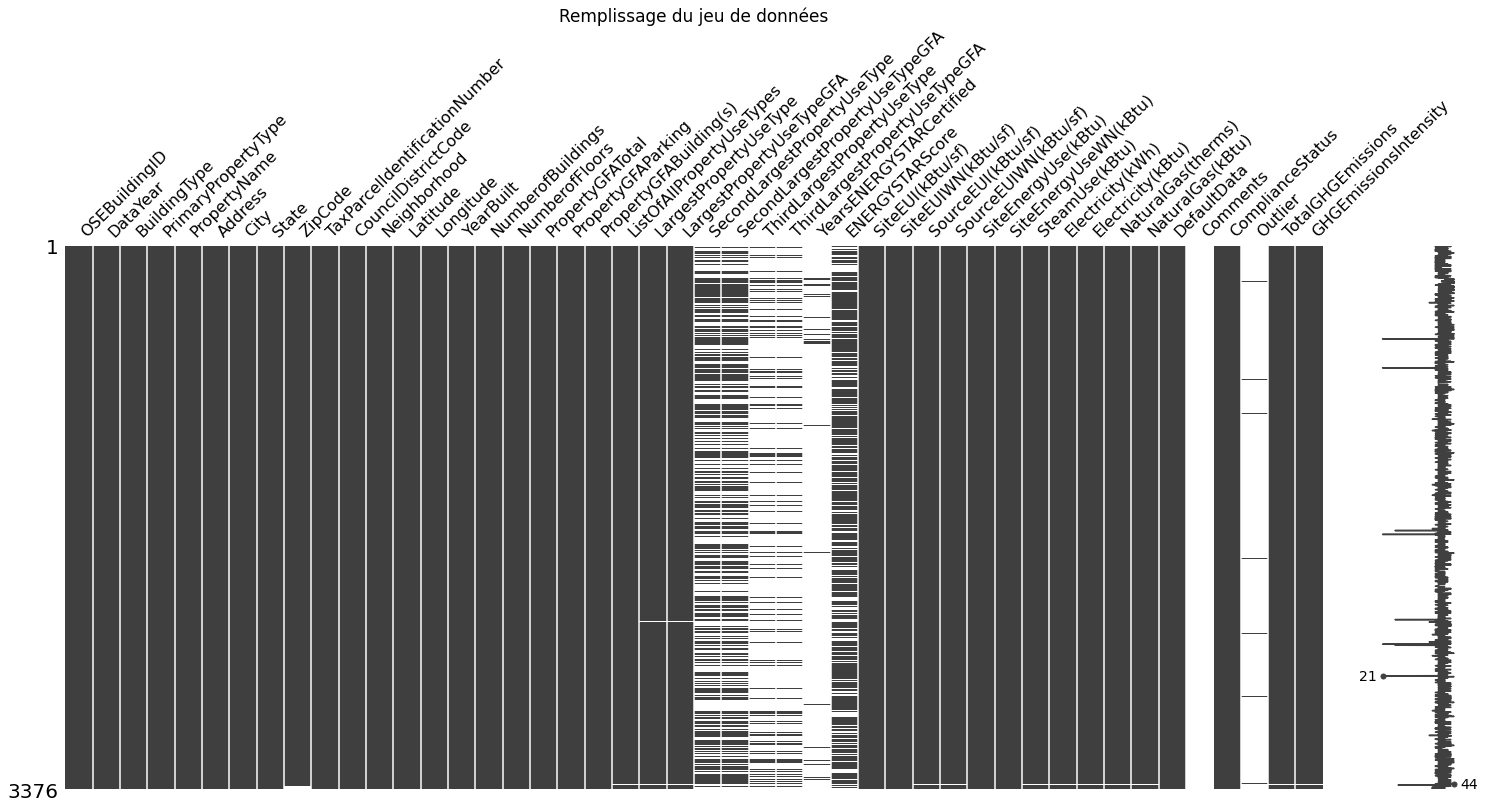

In [4]:
# Représentation du remplissage du jeu de données
msno.matrix(data)
plt.title('Remplissage du jeu de données',fontsize=17);

In [5]:
# Remplissage du jeu de données en % du nombre total de données
(1-round(data.isna().mean().mean(),3))*100

87.2

In [6]:
# Nb de valeurs manquantes par variable
data.isna().sum()

OSEBuildingID                         0
DataYear                              0
BuildingType                          0
PrimaryPropertyType                   0
PropertyName                          0
Address                               0
City                                  0
State                                 0
ZipCode                              16
TaxParcelIdentificationNumber         0
CouncilDistrictCode                   0
Neighborhood                          0
Latitude                              0
Longitude                             0
YearBuilt                             0
NumberofBuildings                     8
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking                    0
PropertyGFABuilding(s)                0
ListOfAllPropertyUseTypes             9
LargestPropertyUseType               20
LargestPropertyUseTypeGFA            20
SecondLargestPropertyUseType       1697
SecondLargestPropertyUseTypeGFA    1697


Le jeu de données est plutôt bien rempli avec un taux de remplissage à  87%.

Il est normal que les variables :
- SecondLargestPropertyUseType 
- SecondLargestPropertyUseTypeGFA    
- ThirdLargestPropertyUseType        
- ThirdLargestPropertyUseTypeGFA

comportent des valeurs manquantes, si le bâtiment ne possède qu'un seul usage.

La colonne "Comments" est entièrement vide

## Observation des colonnes

In [7]:
# Liste des variables
data.columns.unique()

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'DefaultData', 'Comments', 'ComplianceStatus',
       'Outlier

In [8]:
# Observations des valeurs uniques prises par les variables catégorielles
print('OBSERVATIONS DES VALEURS PRISES PAR LES VARIABLES CATEGORIELLES : \n\n' )
for col in data.select_dtypes(include='object'):
    print( col + ': \n' + str(data[col].unique())+'\n')

OBSERVATIONS DES VALEURS PRISES PAR LES VARIABLES CATEGORIELLES : 


BuildingType: 
['NonResidential' 'Nonresidential COS' 'Multifamily MR (5-9)'
 'SPS-District K-12' 'Campus' 'Multifamily LR (1-4)'
 'Multifamily HR (10+)' 'Nonresidential WA']

PrimaryPropertyType: 
['Hotel' 'Other' 'Mid-Rise Multifamily' 'Mixed Use Property' 'K-12 School'
 'University' 'Small- and Mid-Sized Office' 'Self-Storage Facility'
 'Warehouse' 'Large Office' 'Senior Care Community' 'Medical Office'
 'Retail Store' 'Hospital' 'Residence Hall' 'Distribution Center'
 'Worship Facility' 'Low-Rise Multifamily' 'Supermarket / Grocery Store'
 'Laboratory' 'Refrigerated Warehouse' 'Restaurant'
 'High-Rise Multifamily' 'Office']

PropertyName: 
['Mayflower park hotel' 'Paramount Hotel' '5673-The Westin Seattle' ...
 'Queen Anne Pool' 'South Park Community Center'
 'Van Asselt Community Center']

Address: 
['405 Olive way' '724 Pine street' '1900 5th Avenue' ... '1920 1st Ave W'
 '8319 8th Ave S' '2820 S Myrtle St']

Ci

# <a name="C2">2. Nettoyage des données</a>

## 2.1 Filtrage sur les bâtiments non destinés à l'habitation
Dans ce projet non travaillons uniquement sur les bâtiments non destinés à l'habitation.

On filtre sur la variable 'BuildingType', définie par  "City of Seattle building type classification".

In [9]:
# Liste des types de bâtiments correspondant aux bâtiments non destinés à l'habitation
building_types=['NonResidential',
                'Nonresidential COS',
                'SPS-District K-12',
                'Campus',
                'Nonresidential WA']

In [10]:
# Filtrage sur les bâtiments non destinés à l'habitation
data=data.loc[data['BuildingType'].isin(building_types)]
data

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3.946027e+06,12764.529300,1.276453e+06,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3.242851e+06,51450.816410,5.145082e+06,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,4.952666e+07,14938.000000,1.493800e+06,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2.768924e+06,18112.130860,1.811213e+06,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5.368607e+06,88039.984380,8.803998e+06,False,NaN,Compliant,NaN,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,50222,2016,Nonresidential COS,Office,Horticulture building,1600 S Dakota St,Seattle,WA,NaN,1624049080,...,1.536550e+05,5.242709e+05,3254.750244,3.254750e+05,True,NaN,Error - Correct Default Data,NaN,20.94,1.70
3372,50223,2016,Nonresidential COS,Other,International district/Chinatown CC,719 8th Ave S,Seattle,WA,NaN,3558300000,...,1.162210e+05,3.965461e+05,5537.299805,5.537300e+05,False,NaN,Compliant,NaN,32.17,2.01
3373,50224,2016,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,Seattle,WA,NaN,1794501150,...,5.252517e+05,1.792159e+06,39737.390630,3.973739e+06,False,NaN,Compliant,NaN,223.54,16.99
3374,50225,2016,Nonresidential COS,Mixed Use Property,South Park Community Center,8319 8th Ave S,Seattle,WA,NaN,7883603155,...,1.022480e+05,3.488702e+05,3706.010010,3.706010e+05,False,NaN,Compliant,NaN,22.11,1.57


Après sélection des bâtiments non destinés à l'habitation, on passe de 3.376 à 1.668 bâtiments.

## 2.2 Doublons
Recherche de doublons. On s'interresse à la variable "OSEBuildingID" : A unique identifier assigned to each property covered by the Seattle Benchmarking Ordinance for tracking and identification purposes.

In [11]:
# Existe-t-il des lignes identiques ? --> NON
data.duplicated().sum()

0

In [12]:
# Y a t-il des doublons sur l'identifiant du bâtiment ? --> NON
data.loc[(data['OSEBuildingID'].duplicated(keep=False))]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity


## 2.3 Traitement des outliers
Le traitement des outliers s'effectue sur les 2 variables suivantes : 
- "Outliers" : Whether a property is a high or low outlier (Y/N)
- "ComplianceStatus" : Whether a property has met energy benchmarking requirements for the current reporting year.

### Colonne "Outliers"

In [13]:
# valeurs uniques prises par la colonnes "Outliers"
data['Outlier'].unique().tolist()

[nan, 'High outlier', 'Low outlier']

In [14]:
# Combien de bâtiments "High outlier"? --> 2 bâtiments
data.loc[(data['Outlier']=='High outlier')].shape

(2, 46)

In [15]:
# Combien de bâtiments "Low outlier" --> 15 bâtiments
data.loc[(data['Outlier']=='Low outlier')].shape

(15, 46)

In [16]:
# Suppression des bâtiments High et Low outliers
outlier_mask=(data['Outlier']=='Low outlier')|(data['Outlier']=='High outlier')
data=data.loc[~outlier_mask]
data

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3.946027e+06,12764.529300,1.276453e+06,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3.242851e+06,51450.816410,5.145082e+06,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,4.952666e+07,14938.000000,1.493800e+06,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2.768924e+06,18112.130860,1.811213e+06,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5.368607e+06,88039.984380,8.803998e+06,False,NaN,Compliant,NaN,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,50222,2016,Nonresidential COS,Office,Horticulture building,1600 S Dakota St,Seattle,WA,NaN,1624049080,...,1.536550e+05,5.242709e+05,3254.750244,3.254750e+05,True,NaN,Error - Correct Default Data,NaN,20.94,1.70
3372,50223,2016,Nonresidential COS,Other,International district/Chinatown CC,719 8th Ave S,Seattle,WA,NaN,3558300000,...,1.162210e+05,3.965461e+05,5537.299805,5.537300e+05,False,NaN,Compliant,NaN,32.17,2.01
3373,50224,2016,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,Seattle,WA,NaN,1794501150,...,5.252517e+05,1.792159e+06,39737.390630,3.973739e+06,False,NaN,Compliant,NaN,223.54,16.99
3374,50225,2016,Nonresidential COS,Mixed Use Property,South Park Community Center,8319 8th Ave S,Seattle,WA,NaN,7883603155,...,1.022480e+05,3.488702e+05,3706.010010,3.706010e+05,False,NaN,Compliant,NaN,22.11,1.57


### Colonne "ComplianceStatus"
- ComplianceStatus : Whether a property has met energy benchmarking requirements for the current reporting year.
- 4 valeurs possibles : 'Compliant', 'Error - Correct Default Data', 'Missing Data', 'Non-Compliant'
- On ne va conserver que les bâtiments qui ont un statut de compliance à "Compliant"

In [17]:
# valeurs possibles pour le statut de compliance :
data['ComplianceStatus'].unique().tolist()

['Compliant', 'Error - Correct Default Data', 'Missing Data', 'Non-Compliant']

In [18]:
# Combien de batiments avec un status " Compliant"
data.loc[data['ComplianceStatus']=='Compliant'].shape

(1548, 46)

In [19]:
# On conserve uniquement les bâtiments qui ont status "Compliant"
data=data.loc[data['ComplianceStatus']=='Compliant']
data

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3.946027e+06,12764.529300,1.276453e+06,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3.242851e+06,51450.816410,5.145082e+06,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,4.952666e+07,14938.000000,1.493800e+06,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2.768924e+06,18112.130860,1.811213e+06,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5.368607e+06,88039.984380,8.803998e+06,False,NaN,Compliant,NaN,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3370,50221,2016,Nonresidential COS,Other,High Point Community Center,6920 34th Ave SW,Seattle,WA,NaN,2524039059,...,1.853347e+05,6.323620e+05,2997.199951,2.997200e+05,False,NaN,Compliant,NaN,20.33,1.11
3372,50223,2016,Nonresidential COS,Other,International district/Chinatown CC,719 8th Ave S,Seattle,WA,NaN,3558300000,...,1.162210e+05,3.965461e+05,5537.299805,5.537300e+05,False,NaN,Compliant,NaN,32.17,2.01
3373,50224,2016,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,Seattle,WA,NaN,1794501150,...,5.252517e+05,1.792159e+06,39737.390630,3.973739e+06,False,NaN,Compliant,NaN,223.54,16.99
3374,50225,2016,Nonresidential COS,Mixed Use Property,South Park Community Center,8319 8th Ave S,Seattle,WA,NaN,7883603155,...,1.022480e+05,3.488702e+05,3706.010010,3.706010e+05,False,NaN,Compliant,NaN,22.11,1.57


## 2.4 Supression des valeurs négatives
Nous allons supprimer les valeurs négatives d'emission

In [20]:
#Pas de valeurs manquantes pour la variable "TotalGHGEmissions" :
data['TotalGHGEmissions'].isna().sum()

0

In [21]:
#Statistiques descriptives des bâtiments
data.describe()

,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,...,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Comments,TotalGHGEmissions,GHGEmissionsIntensity
count,1548.000000,1548.0,1535.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1.548000e+03,...,1.548000e+03,1.547000e+03,1.548000e+03,1.548000e+03,1.548000e+03,1.548000e+03,1.548000e+03,0.0,1548.000000,1548.000000
mean,16497.944444,2016.0,98116.776547,4.415375,47.616488,-122.333518,1961.644057,1.178941,4.276486,1.213321e+05,...,8.860058e+06,8.441981e+06,5.511831e+05,1.799777e+06,6.140840e+06,2.038297e+04,2.038297e+06,NaN,193.608908,1.667358
std,13827.877766,0.0,18.695570,2.191527,0.046954,0.023264,32.886918,3.039221,6.780694,3.062944e+05,...,3.130568e+07,2.277676e+07,5.718502e+06,6.304430e+06,2.151071e+07,9.710667e+04,9.710667e+06,NaN,779.105278,2.407577
min,1.000000,2016.0,98006.000000,1.000000,47.509590,-122.411820,1900.000000,0.000000,0.000000,1.128500e+04,...,5.713320e+04,0.000000e+00,0.000000e+00,-3.382680e+04,-1.154170e+05,0.000000e+00,0.000000e+00,NaN,-0.800000,-0.020000
25%,602.750000,2016.0,98104.000000,2.000000,47.587855,-122.342997,1930.000000,1.000000,1.000000,2.884325e+04,...,1.251083e+06,1.322090e+06,0.000000e+00,2.142041e+05,7.308642e+05,0.000000e+00,0.000000e+00,NaN,20.655000,0.360000
50%,21180.500000,2016.0,98109.000000,4.000000,47.612710,-122.333160,1965.500000,1.000000,2.000000,4.815900e+04,...,2.732167e+06,2.824097e+06,0.000000e+00,5.117487e+05,1.746086e+06,4.881350e+03,4.881350e+05,NaN,49.845000,0.880000
75%,24609.000000,2016.0,98125.000000,7.000000,47.649060,-122.322700,1989.000000,1.000000,4.000000,1.076615e+05,...,7.294487e+06,7.470130e+06,0.000000e+00,1.543064e+06,5.264935e+06,1.530812e+04,1.530812e+06,NaN,147.227500,1.960000
max,50226.000000,2016.0,98199.000000,7.000000,47.733870,-122.261800,2015.000000,111.000000,99.000000,9.320156e+06,...,8.739237e+08,4.716139e+08,1.349435e+08,1.925775e+08,6.570744e+08,2.979090e+06,2.979090e+08,NaN,16870.980000,34.090000


In [22]:
# Identification des bâtiments avec valeur négative d'emission de CO2
data.loc[data['TotalGHGEmissions']<0]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
3206,49784,2016,NonResidential,Small- and Mid-Sized Office,Bullitt Center,1501 E. Madison St.,Seattle,WA,98122.0,7234600195,...,-33826.80078,-115417.0,0.0,0.0,False,NaN,Compliant,NaN,-0.8,-0.02


In [23]:
# Nous avons un bâtiment avec un valeur d'emission négative, nous le supprimons
data=data.loc[data['TotalGHGEmissions']>=0]
data.shape

(1547, 46)

## 2.5 Nettoyage des modalités de la variable catégorielle "Neighborhood"
Nous allons regrouper les modalités qui renvoient au même quartier telles que 'North' et "NORTH" ou "Central" et "CENTRAL"

In [24]:
# Quelles sont les valeurs uniques prises par 'Neighborhood'
sorted(data['Neighborhood'].unique().tolist())

['BALLARD',
 'Ballard',
 'CENTRAL',
 'Central',
 'DELRIDGE',
 'DELRIDGE NEIGHBORHOODS',
 'DOWNTOWN',
 'Delridge',
 'EAST',
 'GREATER DUWAMISH',
 'LAKE UNION',
 'MAGNOLIA / QUEEN ANNE',
 'NORTH',
 'NORTHEAST',
 'NORTHWEST',
 'North',
 'Northwest',
 'SOUTHEAST',
 'SOUTHWEST']

In [25]:
# Nettoyage des catégories de la variable 'Neighborhood' : regroupement dans une même catégorie des modalités identiques
data['Neighborhood'].replace('Ballard', 'BALLARD', inplace=True)
data['Neighborhood'].replace('Central', 'CENTRAL', inplace=True)
data['Neighborhood'].replace('DELRIDGE NEIGHBORHOODS', 'DELRIDGE', inplace=True)
data['Neighborhood'].replace('Delridge', 'DELRIDGE', inplace=True)
data['Neighborhood'].replace('North', 'NORTH', inplace=True)
data['Neighborhood'].replace('Northwest', 'NORTHWEST', inplace=True)

C:\Users\Léa Zadikian\AppData\Local\Temp\ipykernel_19284\4238618123.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Neighborhood'].replace('Ballard', 'BALLARD', inplace=True)
C:\Users\Léa Zadikian\AppData\Local\Temp\ipykernel_19284\4238618123.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Neighborhood'].replace('Central', 'CENTRAL', inplace=True)
C:\Users\Léa Zadikian\AppData\Local\Temp\ipykernel_19284\4238618123.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

In [26]:
#Vérification de la liste des valeurs uniques obtenues pour la variable 'Neighborhood'
data['Neighborhood'].unique().tolist()

['DOWNTOWN',
 'NORTHEAST',
 'EAST',
 'LAKE UNION',
 'GREATER DUWAMISH',
 'MAGNOLIA / QUEEN ANNE',
 'BALLARD',
 'NORTHWEST',
 'CENTRAL',
 'SOUTHWEST',
 'SOUTHEAST',
 'DELRIDGE',
 'NORTH']

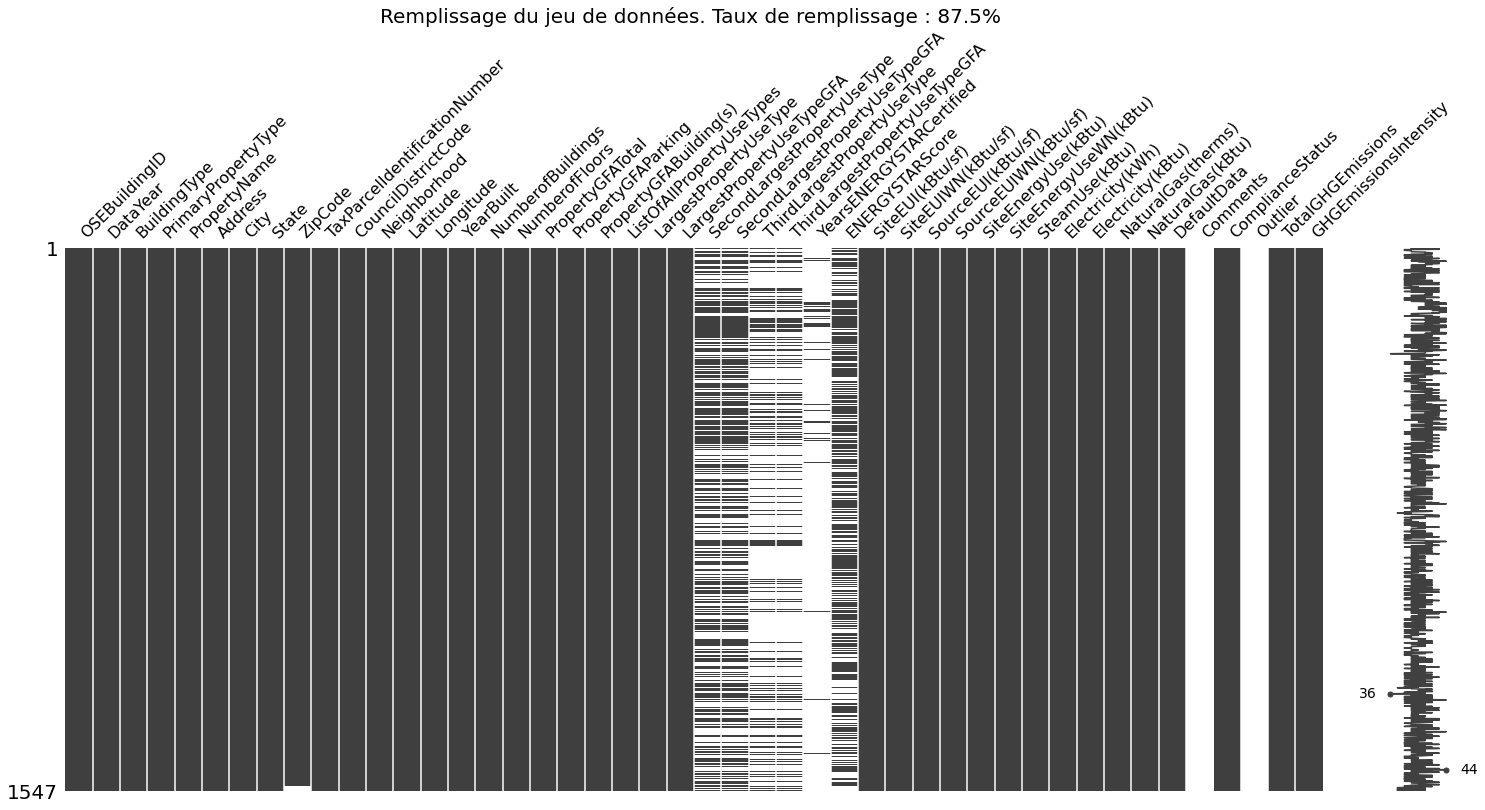

In [27]:
# Représentation du remplissage du jeu de données après nettoyage
msno.matrix(data)
plt.title('Remplissage du jeu de données. Taux de remplissage : 87.5% ',fontsize=20);

In [28]:
#Taux de remplissage du jeu de données en % du nb total de données
(1-round(data.isna().mean().mean(),3))*100

87.5

Le jeu de données est plutôt bien rempli avec un taux de remplissage à  87.5%.

Il est normal que les variables :
- SecondLargestPropertyUseType 
- SecondLargestPropertyUseTypeGFA    
- ThirdLargestPropertyUseType        
- ThirdLargestPropertyUseTypeGFA

comportent des valeurs manquantes, si le bâtiment ne possède qu'un seul usage.

La colonne "Comments" est entièrement vide.

## Selection des colonnes
Permière itération avec une selection de variables plutôt " simple" pour répondre à l'objectif de prédiction :
- Pour la localisation du bâtiment : on ne garde que la variable 'Neighborhood'
- Dans un premier temps, on conserve les propriétés simples des bâtiments : année de construction, nb d'étage, nb de bâtiments, surface. La modélisation prenant en compte les différents usages primaires, secondaires et tertiaires des bâtiments avec les surfaces associées sera effectuée dans un 2ème temps ( cf. feature engineering - partie 2) 
- L'intérêt de 'ENERGYSTARScore'sera également étudié dans un 2ème temps
- Au niveau des mesures de consommation énergétique, on conserve uniquement celle que nous cherchons à prédire 'SiteEnergyUse(kBtu)', notre 1ère target
- On conserve la valeur d'emission de CO2 totale :'TotalGHGEmissions', notre 2ème target

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1547 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    1547 non-null   int64  
 1   DataYear                         1547 non-null   int64  
 2   BuildingType                     1547 non-null   object 
 3   PrimaryPropertyType              1547 non-null   object 
 4   PropertyName                     1547 non-null   object 
 5   Address                          1547 non-null   object 
 6   City                             1547 non-null   object 
 7   State                            1547 non-null   object 
 8   ZipCode                          1534 non-null   float64
 9   TaxParcelIdentificationNumber    1547 non-null   object 
 10  CouncilDistrictCode              1547 non-null   int64  
 11  Neighborhood                     1547 non-null   object 
 12  Latitude            

In [30]:
# Colonnes retenues pour le projet
features_retenues =[
                    #Features :
                    'BuildingType',
                    'PrimaryPropertyType',
                    'Neighborhood',
                    'YearBuilt',
                    'NumberofBuildings',
                    'NumberofFloors',
                    'PropertyGFATotal',
                    'PropertyGFAParking'
    
                   #Targets :
                    'SiteEnergyUse(kBtu)',
                    'TotalGHGEmissions'] 

In [31]:
# filtrage du jeu de données sur les features retenues et les 2 targets
short_data=data.filter(features_retenues)
short_data

,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,TotalGHGEmissions
0,NonResidential,Hotel,DOWNTOWN,1927,1.0,12,88434,249.98
1,NonResidential,Hotel,DOWNTOWN,1996,1.0,11,103566,295.86
2,NonResidential,Hotel,DOWNTOWN,1969,1.0,41,956110,2089.28
3,NonResidential,Hotel,DOWNTOWN,1926,1.0,10,61320,286.43
4,NonResidential,Hotel,DOWNTOWN,1980,1.0,18,175580,505.01
...,...,...,...,...,...,...,...,...
3370,Nonresidential COS,Other,DELRIDGE,1982,1.0,1,18261,20.33
3372,Nonresidential COS,Other,DOWNTOWN,2004,1.0,1,16000,32.17
3373,Nonresidential COS,Other,MAGNOLIA / QUEEN ANNE,1974,1.0,1,13157,223.54
3374,Nonresidential COS,Mixed Use Property,GREATER DUWAMISH,1989,1.0,1,14101,22.11


In [32]:
# Avons-nous des valeurs manquantes ? --> NON
short_data.isna().sum()

BuildingType           0
PrimaryPropertyType    0
Neighborhood           0
YearBuilt              0
NumberofBuildings      0
NumberofFloors         0
PropertyGFATotal       0
TotalGHGEmissions      0
dtype: int64

# <a name="C3">3. Analyse exploratoire</a>

## 3.1 Analyse univariée

In [33]:
short_data.dtypes

BuildingType            object
PrimaryPropertyType     object
Neighborhood            object
YearBuilt                int64
NumberofBuildings      float64
NumberofFloors           int64
PropertyGFATotal         int64
TotalGHGEmissions      float64
dtype: object

### Analyse univarié des variables numériques

In [34]:
# Description statistique des variables numériques
numerical_columns_df=short_data.select_dtypes(include=['int64','float64'])
numerical_columns_df.describe()

,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,TotalGHGEmissions
count,1547.000000,1547.000000,1547.000000,1.547000e+03,1547.000000
mean,1961.610860,1.179056,4.275372,1.213769e+05,193.734577
std,32.871597,3.040201,6.782744,3.063884e+05,779.341518
min,1900.000000,0.000000,0.000000,1.128500e+04,0.000000
25%,1930.000000,1.000000,1.000000,2.884250e+04,20.710000
50%,1965.000000,1.000000,2.000000,4.813900e+04,49.900000
75%,1989.000000,1.000000,4.000000,1.077510e+05,147.315000
max,2015.000000,111.000000,99.000000,9.320156e+06,16870.980000


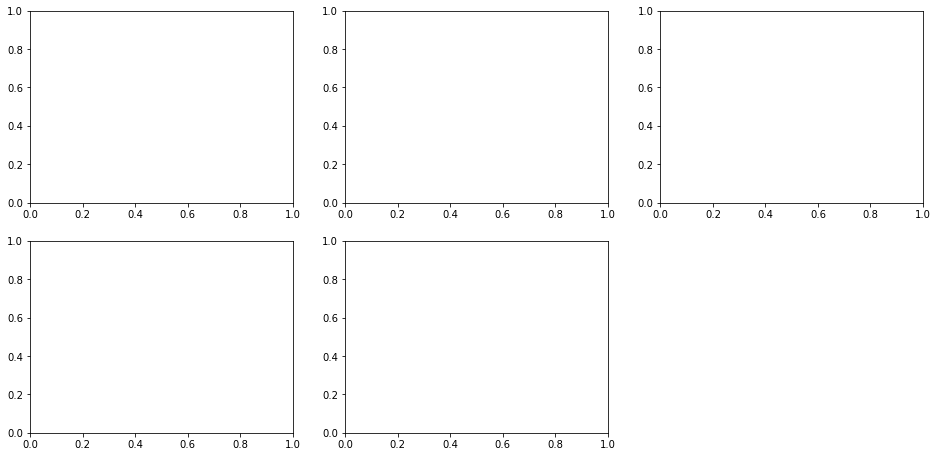

In [35]:
# Représentation graphique de la distribution des variables numériques à l'aide d'histogrammes
X = numerical_columns_df.values
fig=plt.figure(figsize = (16,12))
for feat_idx in range(X.shape[1]):
    ax = fig.add_subplot(3,3, (feat_idx+1))
    #h = ax.hist(X[:, feat_idx], bins=50, color='steelblue', density=True, edgecolor='none')
    #ax.set_title(numerical_columns_df.columns[feat_idx], fontsize=14)
    #plt.grid(axis='y')

In [36]:
short_data.skew()

C:\Users\Léa Zadikian\AppData\Local\Temp\ipykernel_19284\2678637509.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  short_data.skew()


YearBuilt            -0.282502
NumberofBuildings    31.350552
NumberofFloors        5.840819
PropertyGFATotal     18.812533
TotalGHGEmissions    13.719319
dtype: float64

Mis à part pour l'année de construction, on obtient des distributions étalée à droite ( skewness >0) type  loi de puisse. La regression linéaire suppose une relation linéaire entre les variables entrée et de sortie, il sera necessaire d'utiliser une transformation log (cf. Feature enginnering-partie 1)

### Analyse univariée des variables catégorielles

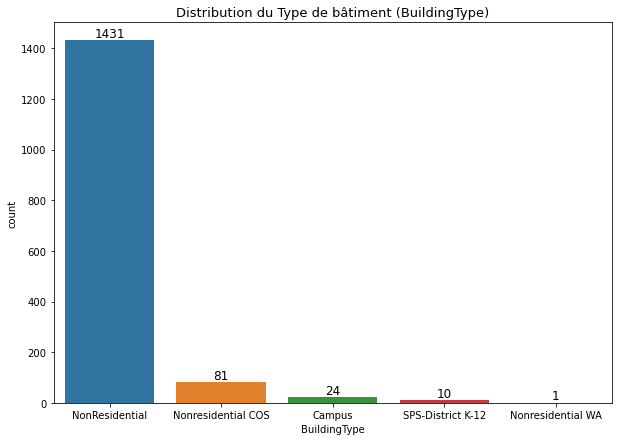

In [37]:
labels =short_data['BuildingType'].value_counts(normalize=True).sort_values(ascending=False).index

# Diagramme en barres (bar chart) pour la variable BuildingType

fig,ax=plt.subplots(figsize=(10,7))
sns.countplot(x = short_data['BuildingType'], order=labels)
plt.title('Distribution du Type de bâtiment (BuildingType)',fontsize=13)
plt.xlabel('BuildingType')
for container in ax.containers:
    ax.bar_label(container,size=12,fmt='%.0f')
plt.show()

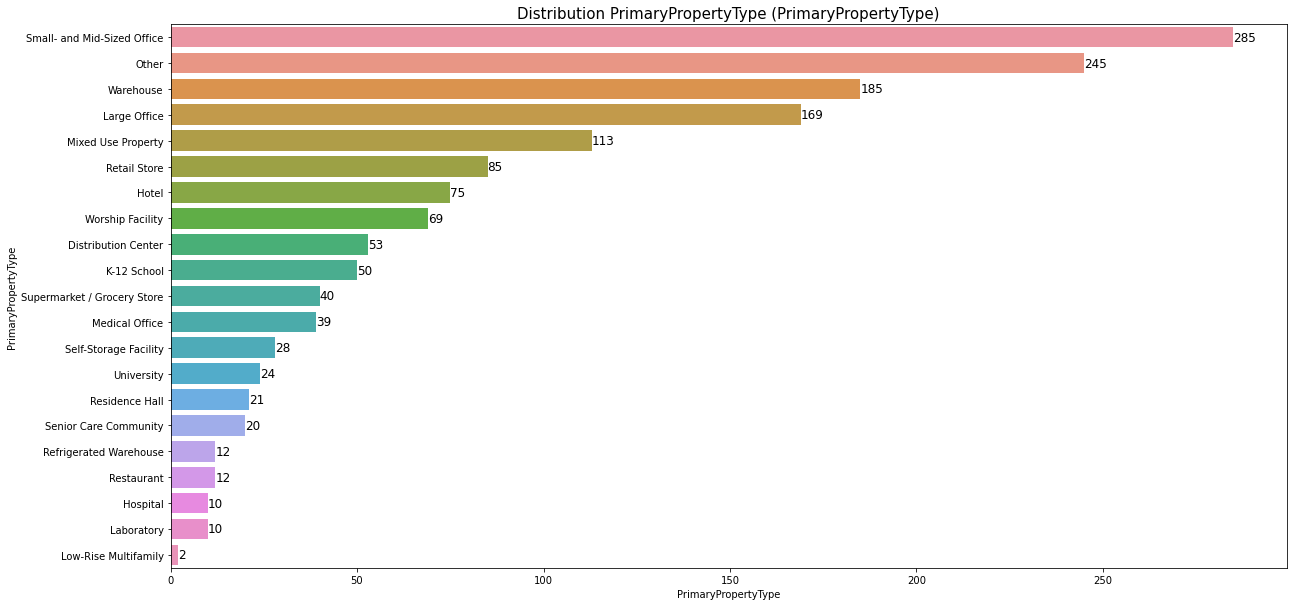

In [38]:
labels =short_data['PrimaryPropertyType'].value_counts(normalize=True).sort_values(ascending=False).index

# Diagramme en barres (bar chart) pour la variable BuildingType
fig,ax=plt.subplots(figsize=(20,10))
sns.countplot(y = short_data['PrimaryPropertyType'],order=labels)
plt.title('Distribution PrimaryPropertyType (PrimaryPropertyType)',fontsize=15)
plt.xlabel('PrimaryPropertyType')

for container in ax.containers:
    ax.bar_label(container,size=12,fmt='%.0f')

plt.show()

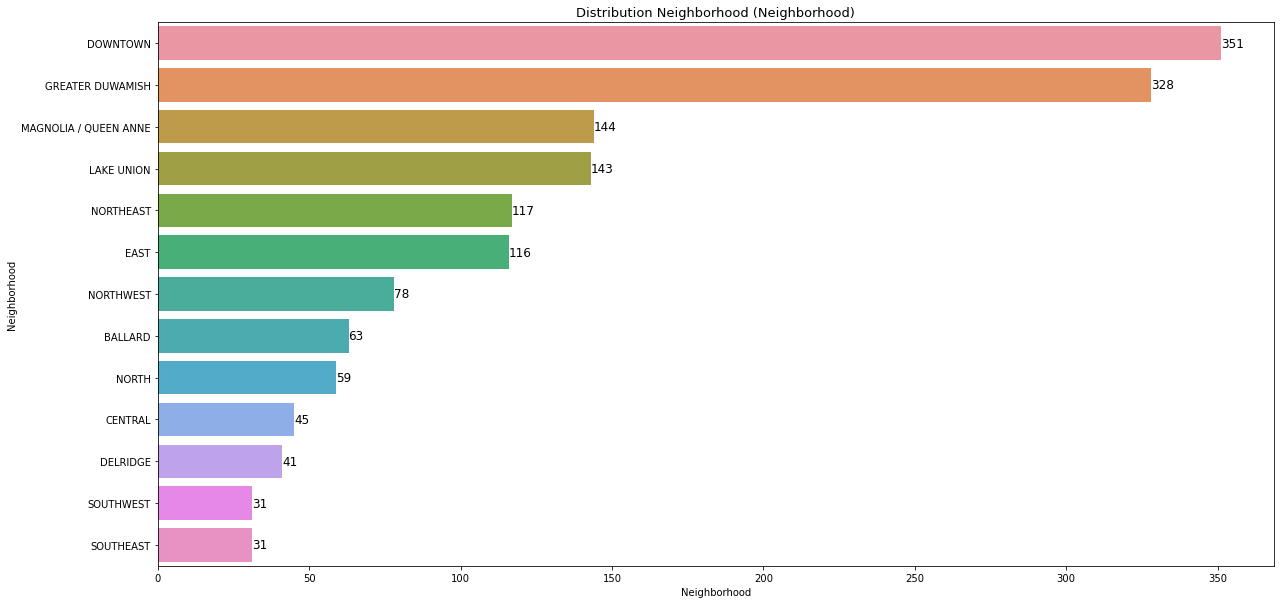

In [39]:
labels =short_data['Neighborhood'].value_counts(normalize=True).sort_values(ascending=False).index

# Diagramme en barres (bar chart) pour la variable BuildingType
fig,ax=plt.subplots(figsize=(20,10))
sns.countplot(y = short_data['Neighborhood'], orient="v",order=labels)
plt.title('Distribution Neighborhood (Neighborhood)',fontsize=13)
plt.xlabel('Neighborhood')
for container in ax.containers:
    ax.bar_label(container,size=12,fmt='%.0f')
plt.show()

## 3.2 Analyse bivariée
Représentation des 2 targets en fonction des features en utilisant pairplit pour mettre en évidence les éventuelles relation linéaires :
- Il est necessaire d'identifier la colinéarité entre les features (fuite de données)

- Cela permet également d'identifier les variables qui sont fortement corrélées à la target.


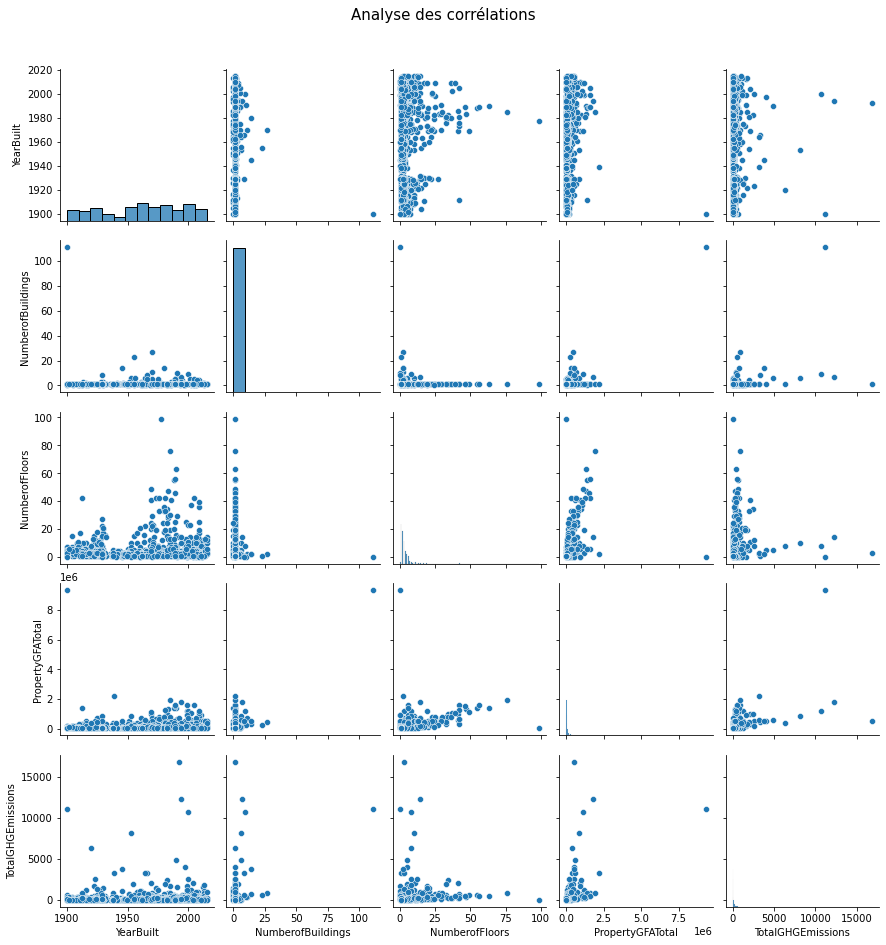

In [40]:
g=sns.pairplot(numerical_columns_df)
g.fig.suptitle('Analyse des corrélations',y=1.05,fontsize=15)
plt.show()

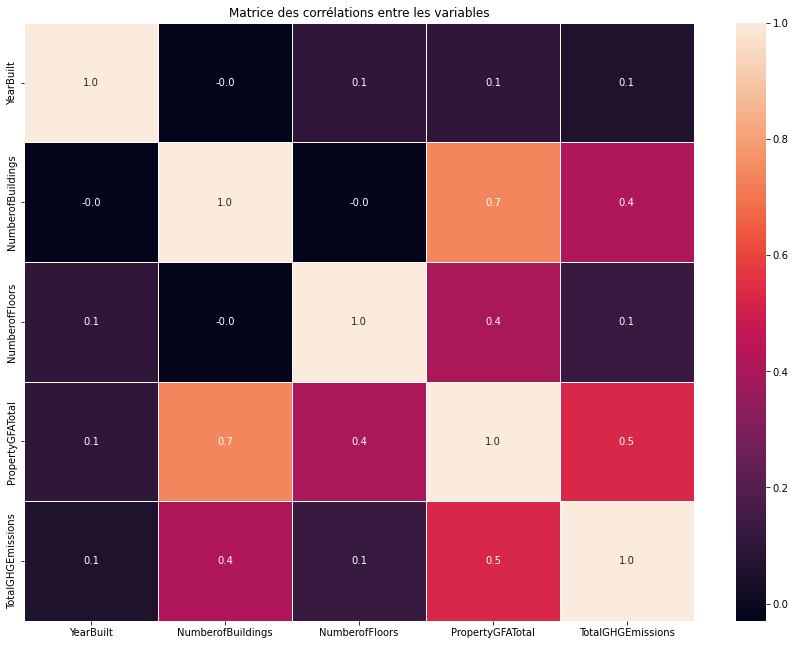

In [41]:
# Matrice des corrélations
plt.figure(figsize=(15,11))
sns.heatmap(data=numerical_columns_df.corr(),annot=True,linewidth=0.5,fmt=".1f")
plt.title('Matrice des corrélations entre les variables')
plt.show()

Etude du data leakage ⇒ Suppression des variables corrélées avec les targets mais susceptibles de ne pas être disponibles dans le futur (risque de bonne performance du modèle d’entraînement, mais mauvaise en production) : SteamUse, NaturalGas, Electricity…
Variables corrélées avec la consommation : La surface (0.8), le nb de bâtiments (0.7)
Consommation et émission : 0.9

Autres corrélations : 
Surface et nb de bâtiments
Surface et nb d’étages

ENERGY SCORE Star : ne semble pas avoir de corrélation avec les autres variables.


# <a name="C4">4. Features engineering - Première itération </a>
- Transformation log des varaiables numériques
- Binning sur les années de construction
- Numérisation des variables catégorielles avec OneHotEncoder()

In [42]:
short_data.dtypes

BuildingType            object
PrimaryPropertyType     object
Neighborhood            object
YearBuilt                int64
NumberofBuildings      float64
NumberofFloors           int64
PropertyGFATotal         int64
TotalGHGEmissions      float64
dtype: object

## 4.1 Transformation log pour les variables numériques
To turn a skewed distriubition into a normal or less skewed distribution. We take the log of the values in a column.We found out that our variables follows a power law distribution (right skewed), which means that log transformation is required as a step of feature engineering step, to convert it to normal distribution.

In [43]:
# Mise à l'échelle log de la consommation d'énergie dans une nouvelle variable'log_SiteEnergyUse(kBtu)'
data['log_SiteEnergyUse(kBtu)']=np.log2(data['SiteEnergyUse(kBtu)']+1)

C:\Users\Léa Zadikian\AppData\Local\Temp\ipykernel_19284\3212589937.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['log_SiteEnergyUse(kBtu)']=np.log2(data['SiteEnergyUse(kBtu)']+1)


C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


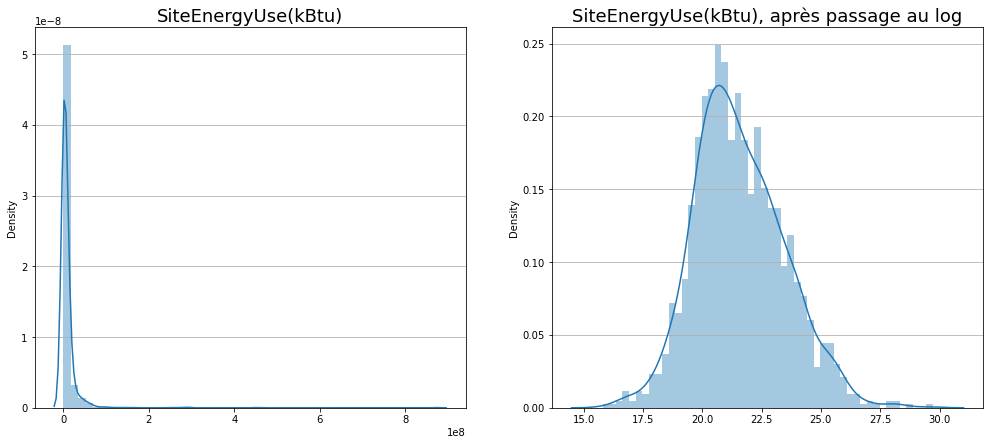

In [44]:
# Représentation graphique de la distribution de la consommation, avant et après transformation logarithmique

fig=plt.figure(figsize = (17,7))

ax = fig.add_subplot(1,2, 1)
sns.distplot(x=data['SiteEnergyUse(kBtu)'],bins=50,)
ax.set_title('SiteEnergyUse(kBtu)', fontsize=18)
plt.grid(axis='y')

ax = fig.add_subplot(1,2, 2)
sns.distplot(x=data['log_SiteEnergyUse(kBtu)'],bins=50,)
ax.set_title('SiteEnergyUse(kBtu), après passage au log', fontsize=18)
plt.grid(axis='y')

In [45]:
# Mise à l'échelle log de l'emission de CO2 'TotalGHGEmissions' dans une nouvelle variable log_TotalGHGEmissions
data['log_TotalGHGEmissions']=np.log2(data['TotalGHGEmissions']+1)

C:\Users\Léa Zadikian\AppData\Local\Temp\ipykernel_19284\1941994538.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['log_TotalGHGEmissions']=np.log2(data['TotalGHGEmissions']+1)


C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


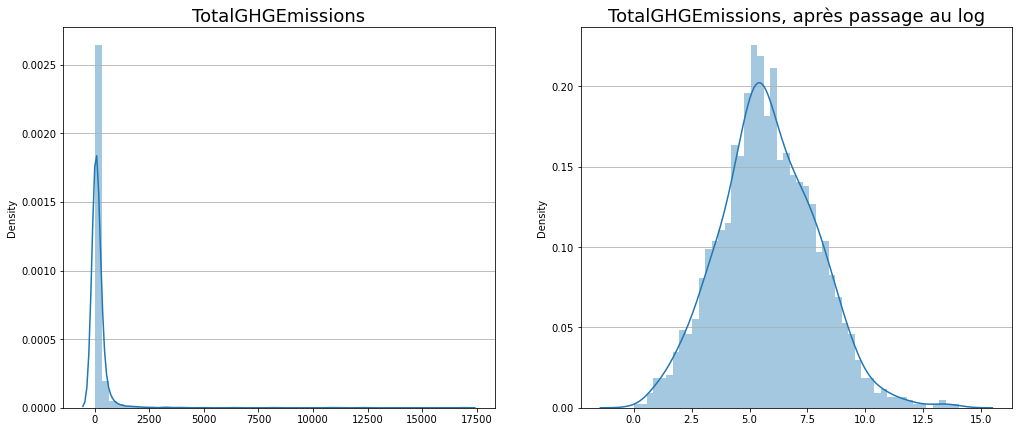

In [46]:
# Représentation graphique de la distribution des émissions, avant et après transformation logarithmique

fig=plt.figure(figsize = (17,7))

ax = fig.add_subplot(1,2, 1)
sns.distplot(x=data['TotalGHGEmissions'],bins=50,)

ax.set_title('TotalGHGEmissions', fontsize=18)
plt.grid(axis='y')
ax = fig.add_subplot(1,2, 2)
sns.distplot(x=data['log_TotalGHGEmissions'],bins=50,)

ax.set_title('TotalGHGEmissions, après passage au log', fontsize=18)
plt.grid(axis='y')

Les données sont plus normalement distribués après tranformation logarithmique

In [47]:
# Mise à l'échelle log Number of Buldings
data['log_NumberofBuildings']=np.log2(data['NumberofBuildings']+1)

C:\Users\Léa Zadikian\AppData\Local\Temp\ipykernel_19284\3307227100.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['log_NumberofBuildings']=np.log2(data['NumberofBuildings']+1)


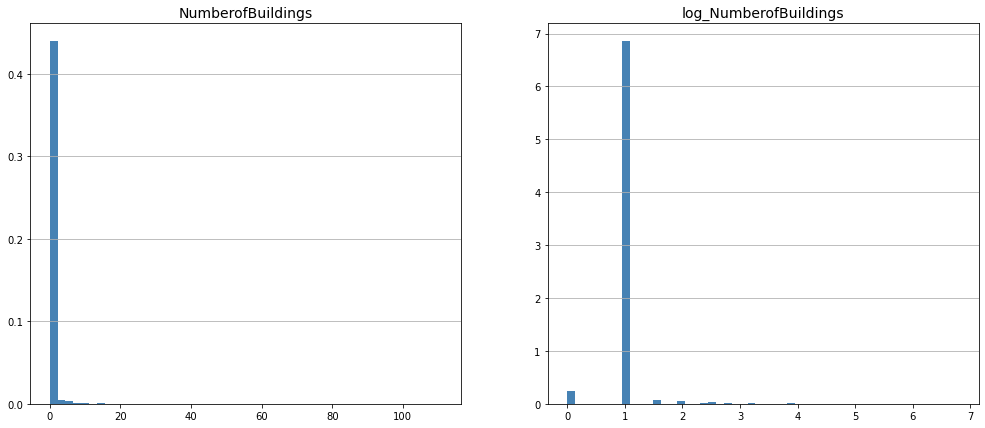

In [48]:
# Représentation graphique de la distribution du nombre d'étages, avant et après transformation logarithmique

fig=plt.figure(figsize = (17,7))

ax = fig.add_subplot(1,2, 1)
h = ax.hist(data['NumberofBuildings'], bins=50, color='steelblue', density=True, edgecolor='none')
ax.set_title('NumberofBuildings', fontsize=14)
plt.grid(axis='y')
ax = fig.add_subplot(1,2, 2)
h = ax.hist(data['log_NumberofBuildings'], bins=50, color='steelblue', density=True,edgecolor='none')
ax.set_title('log_NumberofBuildings', fontsize=14)
plt.grid(axis='y')

In [49]:
# Mise à l'échelle log Number of floors
data['log_NumberofFloors']=np.log2(data['NumberofFloors']+1)

C:\Users\Léa Zadikian\AppData\Local\Temp\ipykernel_19284\2007306456.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['log_NumberofFloors']=np.log2(data['NumberofFloors']+1)


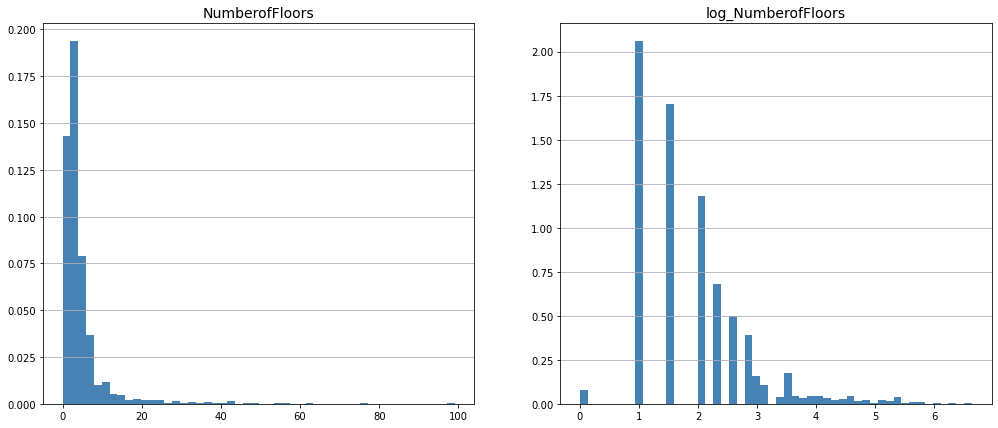

In [50]:
# Représentation graphique de la distribution du nombre d'étages, avant et après transformation logarithmique
fig=plt.figure(figsize = (17,7))

ax = fig.add_subplot(1,2, 1)
h = ax.hist(data['NumberofFloors'], bins=50, color='steelblue', density=True, edgecolor='none')
ax.set_title('NumberofFloors', fontsize=14)
plt.grid(axis='y')
ax = fig.add_subplot(1,2, 2)
h = ax.hist(data['log_NumberofFloors'], bins=50, color='steelblue', density=True,edgecolor='none')
ax.set_title('log_NumberofFloors', fontsize=14)
plt.grid(axis='y')

In [51]:
# Mise à l'échelle log de la Surface totale
data['log_PropertyGFATotal']=np.log2(data['PropertyGFATotal']+1)

C:\Users\Léa Zadikian\AppData\Local\Temp\ipykernel_19284\2981384926.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['log_PropertyGFATotal']=np.log2(data['PropertyGFATotal']+1)


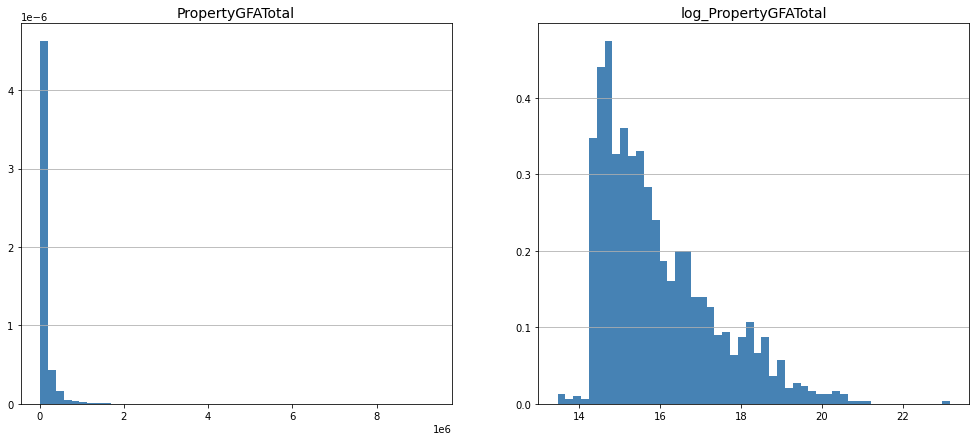

In [52]:
# Représentation graphique de la distribution de la surface totale, avant et après transformation logarithmique

fig=plt.figure(figsize = (17,7))

ax = fig.add_subplot(1,2, 1)
h = ax.hist(data['PropertyGFATotal'], bins=50, color='steelblue', density=True, edgecolor='none')
ax.set_title('PropertyGFATotal', fontsize=14)
plt.grid(axis='y')
ax = fig.add_subplot(1,2, 2)
h = ax.hist(data['log_PropertyGFATotal'], bins=50, color='steelblue', density=True,edgecolor='none')
ax.set_title('log_PropertyGFATotal', fontsize=14)
plt.grid(axis='y')

In [53]:
# Mise à l'échelle log surface de parking
data['log_PropertyGFAParking']=np.log2(data['PropertyGFAParking']+1)

C:\Users\Léa Zadikian\AppData\Local\Temp\ipykernel_19284\2846067227.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['log_PropertyGFAParking']=np.log2(data['PropertyGFAParking']+1)


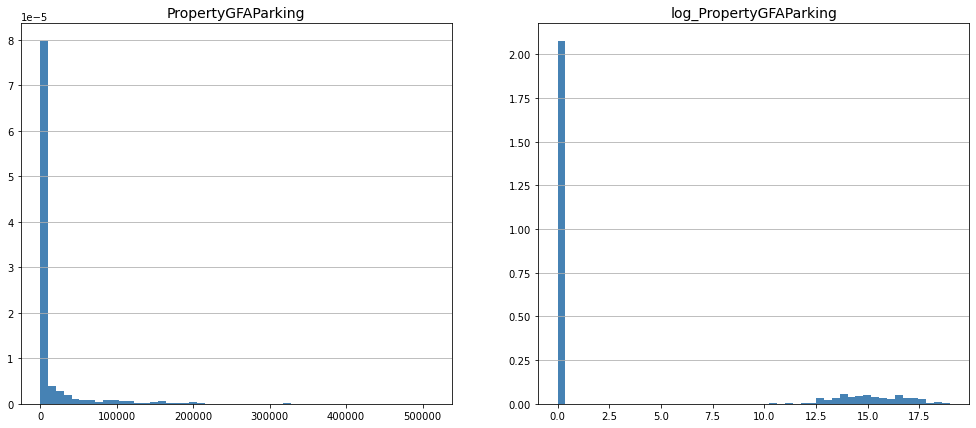

In [54]:
# Représentation graphique de la distribution de la surface de parking, avant et après transformation logarithmique

fig=plt.figure(figsize = (17,7))

ax = fig.add_subplot(1,2, 1)
h = ax.hist(data['PropertyGFAParking'], bins=50, color='steelblue', density=True, edgecolor='none')
ax.set_title('PropertyGFAParking', fontsize=14)
plt.grid(axis='y')
ax = fig.add_subplot(1,2, 2)
h = ax.hist(data['log_PropertyGFAParking'], bins=50, color='steelblue', density=True,edgecolor='none')
ax.set_title('log_PropertyGFAParking', fontsize=14)
plt.grid(axis='y')

## 4.2 Binning sur l'année de construction du bâtiment
Numerical Binning on 'Yearbuilt': to make the model more robust and prevent overfitting ( however it has a cost to the performance). 

In [55]:
#Description statistique de la variable YearBuilt
data['YearBuilt'].describe()

count    1547.000000
mean     1961.610860
std        32.871597
min      1900.000000
25%      1930.000000
50%      1965.000000
75%      1989.000000
max      2015.000000
Name: YearBuilt, dtype: float64

Les années de construction des bâtiments vont de 1900 à 2015. Nous allons regrouper les années de construction par décénnies.

In [56]:
# Création des catégories et des labels associés
years_bins=[1900, 1910, 1920, 1930, 1940,1950,1960,1970,1980,1990,2000,2010,2015]
years_labels=["1900's", "1910's", "1920's", "1930's","1940's", "1950's", "1960's", "1970's","1980's", "1990's", "2000's", "2010's"]

# Création d'une nouvelle variable 'YearBuiltLabel'
data['YearBuiltLabel'] = pd.cut(x=data['YearBuilt'], bins=years_bins,labels=years_labels,include_lowest=True)
  
# Check the number of values in each bin
print("\nNb de bâtiments par décennies: ")
print(data['YearBuiltLabel'].value_counts())
print("\nNb total de label créé : "+ str(data['YearBuiltLabel'].value_counts().sum()))


Nb de bâtiments par décennies: 
1960's    215
1920's    162
1950's    161
2000's    157
1980's    156
1990's    151
1970's    149
1900's    146
1910's     96
1940's     70
2010's     47
1930's     37
Name: YearBuiltLabel, dtype: int64

Nb total de label créé : 1547


C:\Users\Léa Zadikian\AppData\Local\Temp\ipykernel_19284\3190037726.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['YearBuiltLabel'] = pd.cut(x=data['YearBuilt'], bins=years_bins,labels=years_labels,include_lowest=True)


## 4.3 Numérisation des variables catégorielles avec OneHotEncoder
Many machine learning algorithms cannot operate on label data directly. They require all input variables and output variables to be numeric. One hot encoding is a process of converting categorical data variables so they can be provided to machine learning algorithms to improve predictions.

In [57]:
data.reset_index(inplace=True)

In [58]:
variables_categ =['BuildingType','PrimaryPropertyType','Neighborhood','YearBuiltLabel']
categ_features=data.filter(variables_categ)
categ_features

,BuildingType,PrimaryPropertyType,Neighborhood,YearBuiltLabel
0,NonResidential,Hotel,DOWNTOWN,1920's
1,NonResidential,Hotel,DOWNTOWN,1990's
2,NonResidential,Hotel,DOWNTOWN,1960's
3,NonResidential,Hotel,DOWNTOWN,1920's
4,NonResidential,Hotel,DOWNTOWN,1970's
...,...,...,...,...
1542,Nonresidential COS,Other,DELRIDGE,1980's
1543,Nonresidential COS,Other,DOWNTOWN,2000's
1544,Nonresidential COS,Other,MAGNOLIA / QUEEN ANNE,1970's
1545,Nonresidential COS,Mixed Use Property,GREATER DUWAMISH,1980's


In [59]:
# Nombre de valeurs uniques prises par les variables catégorielles
categ_features.nunique()

BuildingType            5
PrimaryPropertyType    21
Neighborhood           13
YearBuiltLabel         12
dtype: int64

In [60]:
# Somme des nb de valeurs uniques prises par les variables categ --> devra être égale au nb de variables créées après OneHotEncoder
categ_features.nunique().sum()

51

Le résultat du OneHotEncoder devra donc comporter 51 colonnes.

In [61]:
# EXEMPLE SUR Neighborhood OneHotEncoder()
ohe = preprocessing.OneHotEncoder()
categ_features_ohe_trans = ohe.fit_transform(data['Neighborhood'].values.reshape(-1, 1)).toarray()


print("Output features names : ")
print(ohe.get_feature_names_out())
print("The original data :\n")
print(data['Neighborhood'].tail(10))
print("\nThe transform data using OneHotEncoder :")
np.set_printoptions(threshold=np.inf)
print(categ_features_ohe_trans)
print("\nTaille : ")
print(categ_features_ohe_trans.shape) # on vérifie le nombre de colonnes du ohe

Output features names : 
['x0_BALLARD' 'x0_CENTRAL' 'x0_DELRIDGE' 'x0_DOWNTOWN' 'x0_EAST'
 'x0_GREATER DUWAMISH' 'x0_LAKE UNION' 'x0_MAGNOLIA / QUEEN ANNE'
 'x0_NORTH' 'x0_NORTHEAST' 'x0_NORTHWEST' 'x0_SOUTHEAST' 'x0_SOUTHWEST']
The original data :

1537                    NORTH
1538                  BALLARD
1539                  BALLARD
1540                     EAST
1541                  CENTRAL
1542                 DELRIDGE
1543                 DOWNTOWN
1544    MAGNOLIA / QUEEN ANNE
1545         GREATER DUWAMISH
1546         GREATER DUWAMISH
Name: Neighborhood, dtype: object

The transform data using OneHotEncoder :
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 

In [62]:
# EXEMPLE sur Neighborhood
print("Variable catégorielle 'Neighborhood'\nDonnées d'origine, 10 dernières lignes.")
data.loc[:,['Neighborhood']].tail(10)

Variable catégorielle 'Neighborhood'
Données d'origine, 10 dernières lignes.


,Neighborhood
1537,NORTH
1538,BALLARD
1539,BALLARD
1540,EAST
1541,CENTRAL
1542,DELRIDGE
1543,DOWNTOWN
1544,MAGNOLIA / QUEEN ANNE
1545,GREATER DUWAMISH
1546,GREATER DUWAMISH


In [63]:
# EXEMPLE sur Neighborhood
#Transformation de l'array en dataframe
categ_features_ohe_trans_df = pd.DataFrame(categ_features_ohe_trans)
print("Variable catégorielle 'Neighborhood'\nDonnées transformées avec OneHotEncoder, 10 dernières lignes.")
categ_features_ohe_trans_df.tail(10)
# merge with main df on key values
#short_data_ohe = ohe_data.join(categ_features_ohe_trans_df)
#short_data_ohe

Variable catégorielle 'Neighborhood'
Données transformées avec OneHotEncoder, 10 dernières lignes.


,0,1,2,3,4,5,6,7,8,9,10,11,12
1537,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1538,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1539,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1540,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1541,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1542,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1543,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1545,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1546,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
# OneHotEncoder sur l'ensemble des variables catégorielles
ohe = preprocessing.OneHotEncoder()
categ_features_ohe_trans = ohe.fit_transform(categ_features.values).toarray()

# Vérification du résultat obtenu :
print("Output features names : ")
print(ohe.get_feature_names_out())
print("The original data :\n")
print(categ_features)
print("\nThe transform data using OneHotEncoder :")
np.set_printoptions(threshold=np.inf)
print(categ_features_ohe_trans)
print("\nTaille : ")
print(categ_features_ohe_trans.shape) # on vérifie le nombre de colonnes du ohe

Output features names : 
['x0_Campus' 'x0_NonResidential' 'x0_Nonresidential COS'
 'x0_Nonresidential WA' 'x0_SPS-District K-12' 'x1_Distribution Center'
 'x1_Hospital' 'x1_Hotel' 'x1_K-12 School' 'x1_Laboratory'
 'x1_Large Office' 'x1_Low-Rise Multifamily' 'x1_Medical Office'
 'x1_Mixed Use Property' 'x1_Other' 'x1_Refrigerated Warehouse'
 'x1_Residence Hall' 'x1_Restaurant' 'x1_Retail Store'
 'x1_Self-Storage Facility' 'x1_Senior Care Community'
 'x1_Small- and Mid-Sized Office' 'x1_Supermarket / Grocery Store'
 'x1_University' 'x1_Warehouse' 'x1_Worship Facility' 'x2_BALLARD'
 'x2_CENTRAL' 'x2_DELRIDGE' 'x2_DOWNTOWN' 'x2_EAST' 'x2_GREATER DUWAMISH'
 'x2_LAKE UNION' 'x2_MAGNOLIA / QUEEN ANNE' 'x2_NORTH' 'x2_NORTHEAST'
 'x2_NORTHWEST' 'x2_SOUTHEAST' 'x2_SOUTHWEST' "x3_1900's" "x3_1910's"
 "x3_1920's" "x3_1930's" "x3_1940's" "x3_1950's" "x3_1960's" "x3_1970's"
 "x3_1980's" "x3_1990's" "x3_2000's" "x3_2010's"]
The original data :

            BuildingType PrimaryPropertyType           N

In [65]:
# Récupération des variables numériques du modèle
variables_num=['log_NumberofBuildings','log_NumberofFloors','log_PropertyGFATotal','log_PropertyGFAParking','log_TotalGHGEmissions','log_SiteEnergyUse(kBtu)']
model_1_data=data.filter(variables_num)

#Transformation de l'array en dataframe
categ_features_ohe_trans_df = pd.DataFrame(columns = ohe.get_feature_names_out(),data=categ_features_ohe_trans)
categ_features_ohe_trans_df

# Merge du résultat du ohe

#model_1_data=model_1_data.join(categ_features_ohe_trans_df)
#model_1_data

model_1_data= pd.merge(model_1_data,
                       categ_features_ohe_trans_df,
                       left_index = True, 
                       right_index = True
                      )
model_1_data


,log_NumberofBuildings,log_NumberofFloors,log_PropertyGFATotal,log_PropertyGFAParking,log_TotalGHGEmissions,log_SiteEnergyUse(kBtu),x0_Campus,x0_NonResidential,x0_Nonresidential COS,x0_Nonresidential WA,...,x3_1920's,x3_1930's,x3_1940's,x3_1950's,x3_1960's,x3_1970's,x3_1980's,x3_1990's,x3_2000's,x3_2010's
0,1.0,3.700440,16.432330,0.000000,7.971429,22.784838,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,3.584963,16.660205,13.878913,8.213639,22.999884,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,5.392317,19.866819,17.585777,11.029480,26.113208,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,3.459432,15.904094,0.000000,8.167067,22.695954,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,4.247928,17.421777,15.920004,8.983022,23.756602,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542,1.0,1.000000,14.156557,0.000000,4.414812,19.830099,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1543,1.0,1.000000,13.965874,0.000000,5.051807,19.857989,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1544,1.0,1.000000,13.683653,0.000000,7.810829,22.459114,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1545,1.0,1.000000,13.783612,0.000000,4.530445,19.456579,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


**Exportation en fichier.csv du jeu de données nettoyé et issu de la première itération de feature engineering**

Les prédictions de la consommation et des emissions sont effectuées dans un notebook séparé (un notebook par target)

In [66]:
model_1_data.to_csv('2016_Building_Energy_Benchmarking_clean_model_1.csv', index=False)

# <a name="C5">5. Features engineering - Deuxième itération </a>
Nous allons complexifier le modèle dans le but d'essayer d'obtenir un meilleur résultat. Nous allons rajouter aux features les type d'usage des bâtiments, pondérés par la surface de l'usage en pourcentage de la surface totale
Variables concernées : 
- LargestPropertyUseType : The largest use of a property (e.g. office, retail store) by GFA.

- LargestPropertyUseTypeGFA : The gross floor area (GFA) of the largest use of the property.

- SecondLargestPropertyUseType : The second largest use of a property (e.g. office, retail store) by GFA.

- SecondLargestPropertyUseTypeGFA :The gross floor area (GFA) of the second largest use of the property.

- ThirdLargestPropertyUseType :The third largest use of a property (e.g. office, retail store) by GFA.

- ThirdLargestPropertyUseTypeGFA :The gross floor area (GFA) of the third largest use of the property.



In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1547 entries, 0 to 1546
Data columns (total 54 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   index                            1547 non-null   int64   
 1   OSEBuildingID                    1547 non-null   int64   
 2   DataYear                         1547 non-null   int64   
 3   BuildingType                     1547 non-null   object  
 4   PrimaryPropertyType              1547 non-null   object  
 5   PropertyName                     1547 non-null   object  
 6   Address                          1547 non-null   object  
 7   City                             1547 non-null   object  
 8   State                            1547 non-null   object  
 9   ZipCode                          1534 non-null   float64 
 10  TaxParcelIdentificationNumber    1547 non-null   object  
 11  CouncilDistrictCode              1547 non-null   int64   
 12  Neighb

On vérifie que les valeurs manquantes de SecondLargestPropertyUseType et ThirdLargestPropertyUseType correspondent bien à des surfaces d'utilisation à 0, et réciproquement.

In [68]:
data.loc[data['LargestPropertyUseType'].isna(),'LargestPropertyUseTypeGFA']

301    NaN
754    NaN
1251   NaN
1268   NaN
Name: LargestPropertyUseTypeGFA, dtype: float64

In [69]:
data.loc[data['LargestPropertyUseTypeGFA'].isna(),'LargestPropertyUseType']

301     NaN
754     NaN
1251    NaN
1268    NaN
Name: LargestPropertyUseType, dtype: object

In [70]:
data.loc[data['SecondLargestPropertyUseTypeGFA'].isna(),'SecondLargestPropertyUseType'].notna().sum()

0

In [71]:
data.loc[data['ThirdLargestPropertyUseTypeGFA'].isna(),'ThirdLargestPropertyUseType'].notna().sum()

0

In [72]:
data.loc[data['ThirdLargestPropertyUseType'].isna(),'ThirdLargestPropertyUseTypeGFA'].notna().sum()

0

In [73]:
# Remplacement des surface d'utilisation par 0 ( pas d'usage secondaire ou tertiaire pour ce bâtiment)
data['LargestPropertyUseTypeGFA'].fillna(0,inplace=True)
data['SecondLargestPropertyUseTypeGFA'].fillna(0,inplace=True)
data['ThirdLargestPropertyUseTypeGFA'].fillna(0,inplace=True)

C:\Users\Léa Zadikian\AppData\Local\Temp\ipykernel_19284\256335559.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['LargestPropertyUseTypeGFA'].fillna(0,inplace=True)
C:\Users\Léa Zadikian\AppData\Local\Temp\ipykernel_19284\256335559.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['SecondLargestPropertyUseTypeGFA'].fillna(0,inplace=True)
C:\Users\Léa Zadikian\AppData\Local\Temp\ipykernel_19284\256335559.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

In [74]:
#Remplacement des valeurs manquantes d'usage par NA
data['LargestPropertyUseType'].fillna('NA',inplace=True)
data['SecondLargestPropertyUseType'].fillna('NA',inplace=True)
data['ThirdLargestPropertyUseType'].fillna('NA',inplace=True)

C:\Users\Léa Zadikian\AppData\Local\Temp\ipykernel_19284\29127163.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['LargestPropertyUseType'].fillna('NA',inplace=True)
C:\Users\Léa Zadikian\AppData\Local\Temp\ipykernel_19284\29127163.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['SecondLargestPropertyUseType'].fillna('NA',inplace=True)
C:\Users\Léa Zadikian\AppData\Local\Temp\ipykernel_19284\29127163.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

In [75]:
data.loc[data['ThirdLargestPropertyUseType'].isna(),'ThirdLargestPropertyUseTypeGFA']

Series([], Name: ThirdLargestPropertyUseTypeGFA, dtype: float64)

In [76]:
# Liste des nouvelles features que nous allons intégrer à notre modélisation
features_suppl =['LargestPropertyUseType','LargestPropertyUseTypeGFA',
                 'SecondLargestPropertyUseType','SecondLargestPropertyUseTypeGFA',    
                 'ThirdLargestPropertyUseType','ThirdLargestPropertyUseTypeGFA',
                 'PropertyGFATotal'
                ] 

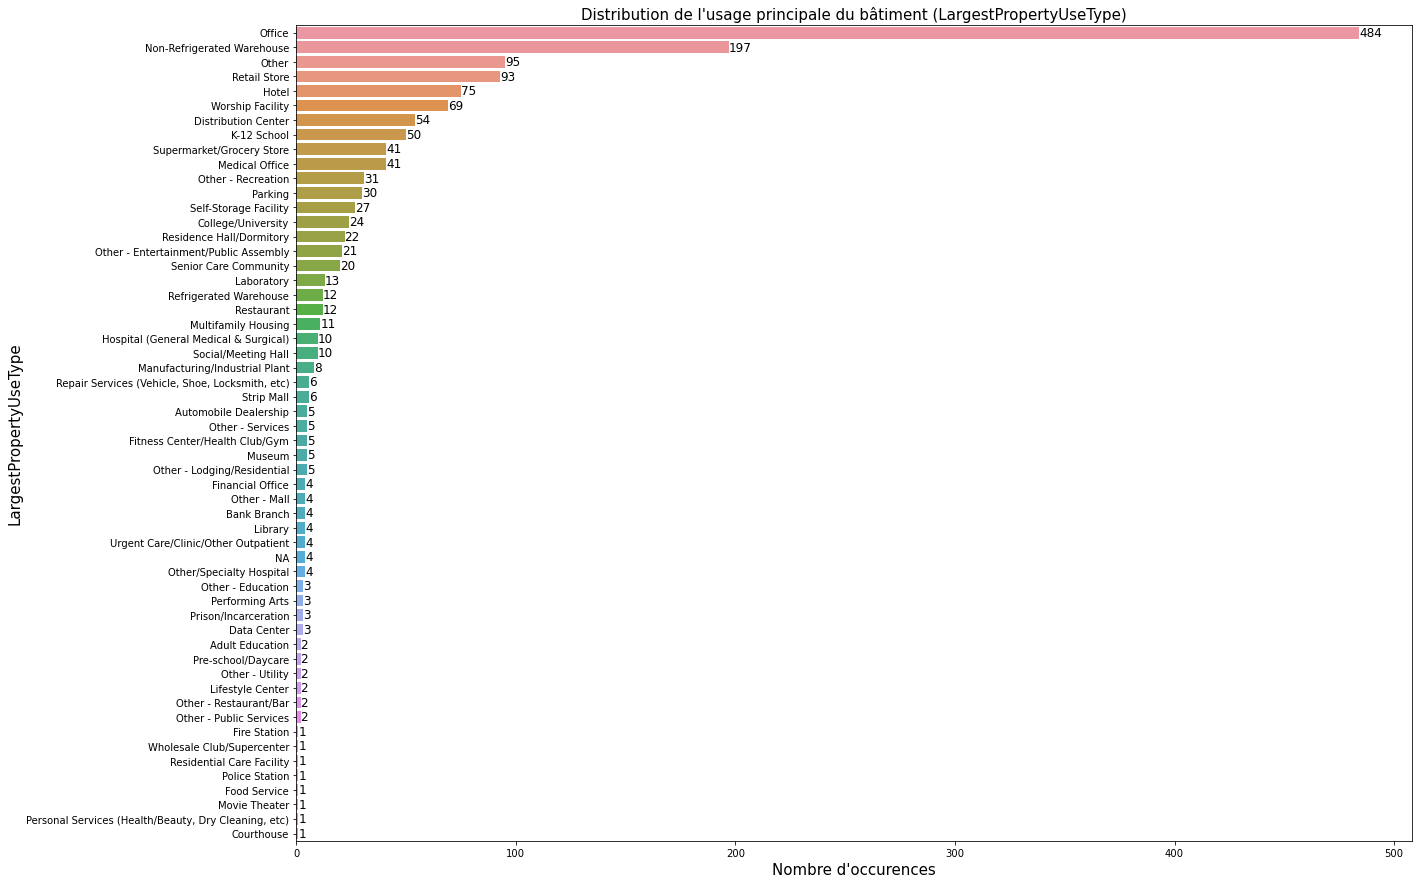

In [77]:
# Représentation graphique de la distribution de la variable LargestPropertyUseType

labels =data['LargestPropertyUseType'].value_counts(normalize=True).sort_values(ascending=False).index

# Diagramme en barres (bar chart) pour la variable catégorielle LargestPropertyUseType
fig,ax=plt.subplots(figsize=(20,15))
sns.countplot(y = data['LargestPropertyUseType'],order=labels)
plt.title("Distribution de l'usage principale du bâtiment (LargestPropertyUseType)",fontsize=15)
plt.ylabel('LargestPropertyUseType',fontsize=15)
plt.xlabel("Nombre d'occurences",fontsize=15)

# Affichage sur le graphique à l'extrêmité de chaque barre du nombre d'occurences 
for container in ax.containers:
    ax.bar_label(container,size=12,fmt='%.0f')

plt.show()

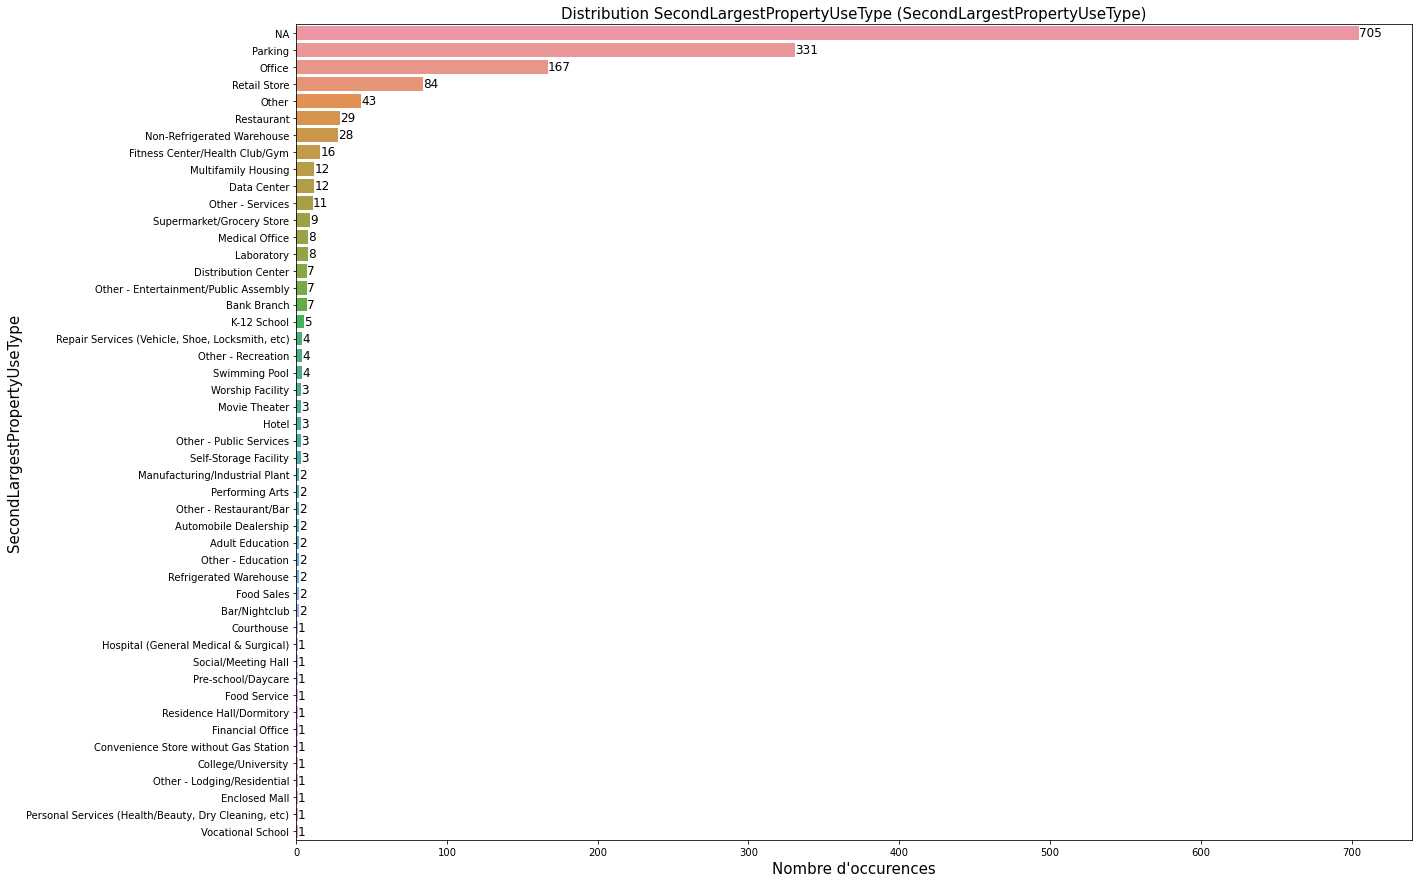

In [78]:
# # Représentation graphique de la distribution de la variable SecondLargestPropertyUseType

labels =data['SecondLargestPropertyUseType'].value_counts(normalize=True).sort_values(ascending=False).index
#values = data['SecondLargestPropertyUseType'].value_counts(normalize=True).sort_values(ascending=False).values

# Diagramme en barres (bar chart) pour la variable SecondLargestPropertyUseType
fig,ax=plt.subplots(figsize=(20,15))
#plt.figure(figsize = (13,8))
sns.countplot(y = data['SecondLargestPropertyUseType'],order=labels)
plt.title('Distribution SecondLargestPropertyUseType (SecondLargestPropertyUseType)',fontsize=15)
plt.ylabel('SecondLargestPropertyUseType',fontsize=15)
plt.xlabel("Nombre d'occurences",fontsize=15)

for container in ax.containers:
    ax.bar_label(container,size=12,fmt='%.0f')

plt.show()

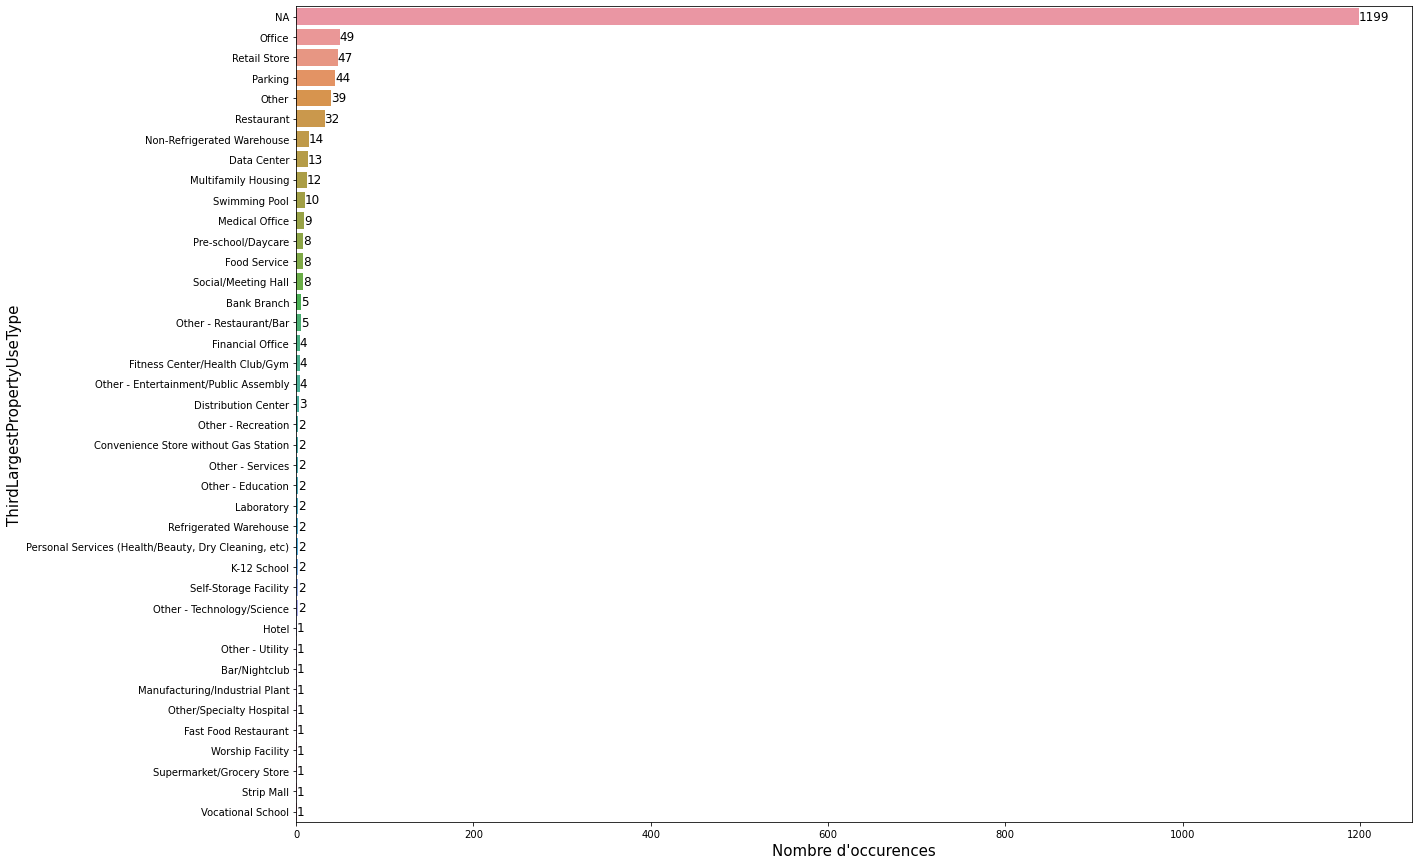

In [79]:
# # Représentation graphique de la distribution de la variable ThirdLargestPropertyUseType
labels =data['ThirdLargestPropertyUseType'].value_counts(normalize=True).sort_values(ascending=False).index
#values = feat_eng_2_data['ThirdLargestPropertyUseType'].value_counts(normalize=True).sort_values(ascending=False).values

# Diagramme en barres (bar chart) pour la variable ThirdLargestPropertyUseType
fig,ax=plt.subplots(figsize=(20,15))
#plt.figure(figsize = (13,8))
sns.countplot(y = data['ThirdLargestPropertyUseType'],order=labels)
plt.ylabel('ThirdLargestPropertyUseType',fontsize=15)
plt.xlabel("Nombre d'occurences",fontsize=15)

for container in ax.containers:
    ax.bar_label(container,size=12,fmt='%.0f')

plt.show()

In [80]:
data['LargestPropertyUseType'].nunique()

56

In [81]:
data['GFA_Property_Use'] = data['LargestPropertyUseTypeGFA'] + data['SecondLargestPropertyUseTypeGFA'] + data['ThirdLargestPropertyUseTypeGFA']
data.loc[data['GFA_Property_Use']==0,'GFA_Property_Use']=data['PropertyGFATotal']
           

C:\Users\Léa Zadikian\AppData\Local\Temp\ipykernel_19284\910793852.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['GFA_Property_Use'] = data['LargestPropertyUseTypeGFA'] + data['SecondLargestPropertyUseTypeGFA'] + data['ThirdLargestPropertyUseTypeGFA']


In [82]:
# Récupération des variables numériques du modèle
variables_num=['log_NumberofBuildings','log_NumberofFloors','log_PropertyGFATotal','log_PropertyGFAParking','log_TotalGHGEmissions','log_SiteEnergyUse(kBtu)']
model_2_data=data.filter(variables_num)
# Merge du résultat du premier ohe
model_2_data=model_2_data.join(categ_features_ohe_trans_df)

In [83]:
model_2_data

,log_NumberofBuildings,log_NumberofFloors,log_PropertyGFATotal,log_PropertyGFAParking,log_TotalGHGEmissions,log_SiteEnergyUse(kBtu),x0_Campus,x0_NonResidential,x0_Nonresidential COS,x0_Nonresidential WA,...,x3_1920's,x3_1930's,x3_1940's,x3_1950's,x3_1960's,x3_1970's,x3_1980's,x3_1990's,x3_2000's,x3_2010's
0,1.0,3.700440,16.432330,0.000000,7.971429,22.784838,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,3.584963,16.660205,13.878913,8.213639,22.999884,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,5.392317,19.866819,17.585777,11.029480,26.113208,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,3.459432,15.904094,0.000000,8.167067,22.695954,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,4.247928,17.421777,15.920004,8.983022,23.756602,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542,1.0,1.000000,14.156557,0.000000,4.414812,19.830099,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1543,1.0,1.000000,13.965874,0.000000,5.051807,19.857989,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1544,1.0,1.000000,13.683653,0.000000,7.810829,22.459114,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1545,1.0,1.000000,13.783612,0.000000,4.530445,19.456579,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [84]:
# OneHotEncoder sur LargestPropertyUseType
ohe_2 = preprocessing.OneHotEncoder(min_frequency=0.02,handle_unknown='infrequent_if_exist')
largest_ohe_trans = ohe_2.fit_transform(data['LargestPropertyUseType'].values.reshape(-1,1)).toarray()

#Pondération : à la place du 1 obtenu par le OneHotEncoder, on indique le % d'utilisation de l'usage en fonction de la surface totale
largest_ohe_trans=largest_ohe_trans*data['LargestPropertyUseTypeGFA'].values.reshape(-1,1)
largest_ohe_trans=largest_ohe_trans/data['GFA_Property_Use'].values.reshape(-1,1)

# Transformation de array en DataFrame
largest_ohe_trans_df=pd.DataFrame(columns = ohe_2.get_feature_names_out(),
                      data = largest_ohe_trans)


# Merge du résultat du 2ème ohe
#model_2_data=model_2_data.join(largest_ohe_trans_df, rsuffix='_largest')
model_2_data= pd.merge(model_2_data,
                       largest_ohe_trans_df,
                       left_index = True, 
                       right_index = True
                      )



# Vérification du résultat obtenu
print("Output features names : ")
print(ohe_2.get_feature_names_out())
print("The original data :\n")
print(data['LargestPropertyUseType'])
print("\nThe transform data using OneHotEncoder :")
np.set_printoptions(threshold=np.inf)
print(largest_ohe_trans)
print("\nTaille : ")
print(largest_ohe_trans.shape)

Output features names : 
['x0_Distribution Center' 'x0_Hotel' 'x0_K-12 School' 'x0_Medical Office'
 'x0_Non-Refrigerated Warehouse' 'x0_Office' 'x0_Other'
 'x0_Other - Recreation' 'x0_Retail Store' 'x0_Supermarket/Grocery Store'
 'x0_Worship Facility' 'x0_infrequent_sklearn']
The original data :

0                    Hotel
1                    Hotel
2                    Hotel
3                    Hotel
4                    Hotel
               ...        
1542    Other - Recreation
1543    Other - Recreation
1544    Other - Recreation
1545    Other - Recreation
1546    Other - Recreation
Name: LargestPropertyUseType, Length: 1547, dtype: object

The transform data using OneHotEncoder :
[[0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.80991831 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0

In [85]:
model_2_data

,log_NumberofBuildings,log_NumberofFloors,log_PropertyGFATotal,log_PropertyGFAParking,log_TotalGHGEmissions,log_SiteEnergyUse(kBtu),x0_Campus,x0_NonResidential,x0_Nonresidential COS,x0_Nonresidential WA,...,x0_K-12 School,x0_Medical Office,x0_Non-Refrigerated Warehouse,x0_Office,x0_Other,x0_Other - Recreation,x0_Retail Store,x0_Supermarket/Grocery Store,x0_Worship Facility,x0_infrequent_sklearn
0,1.0,3.700440,16.432330,0.000000,7.971429,22.784838,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,1.0,3.584963,16.660205,13.878913,8.213639,22.999884,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,1.0,5.392317,19.866819,17.585777,11.029480,26.113208,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,1.0,3.459432,15.904094,0.000000,8.167067,22.695954,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,1.0,4.247928,17.421777,15.920004,8.983022,23.756602,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542,1.0,1.000000,14.156557,0.000000,4.414812,19.830099,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0
1543,1.0,1.000000,13.965874,0.000000,5.051807,19.857989,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0
1544,1.0,1.000000,13.683653,0.000000,7.810829,22.459114,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.576347,0.0,0.0,0.0,0.0
1545,1.0,1.000000,13.783612,0.000000,4.530445,19.456579,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.485868,0.0,0.0,0.0,0.0


In [86]:
largest_ohe_trans_df

,x0_Distribution Center,x0_Hotel,x0_K-12 School,x0_Medical Office,x0_Non-Refrigerated Warehouse,x0_Office,x0_Other,x0_Other - Recreation,x0_Retail Store,x0_Supermarket/Grocery Store,x0_Worship Facility,x0_infrequent_sklearn
0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.809918,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.644776,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1542,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0
1543,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0
1544,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.576347,0.0,0.0,0.0,0.0
1545,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.485868,0.0,0.0,0.0,0.0


In [87]:
model_2_data

,log_NumberofBuildings,log_NumberofFloors,log_PropertyGFATotal,log_PropertyGFAParking,log_TotalGHGEmissions,log_SiteEnergyUse(kBtu),x0_Campus,x0_NonResidential,x0_Nonresidential COS,x0_Nonresidential WA,...,x0_K-12 School,x0_Medical Office,x0_Non-Refrigerated Warehouse,x0_Office,x0_Other,x0_Other - Recreation,x0_Retail Store,x0_Supermarket/Grocery Store,x0_Worship Facility,x0_infrequent_sklearn
0,1.0,3.700440,16.432330,0.000000,7.971429,22.784838,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,1.0,3.584963,16.660205,13.878913,8.213639,22.999884,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,1.0,5.392317,19.866819,17.585777,11.029480,26.113208,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,1.0,3.459432,15.904094,0.000000,8.167067,22.695954,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,1.0,4.247928,17.421777,15.920004,8.983022,23.756602,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542,1.0,1.000000,14.156557,0.000000,4.414812,19.830099,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0
1543,1.0,1.000000,13.965874,0.000000,5.051807,19.857989,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0
1544,1.0,1.000000,13.683653,0.000000,7.810829,22.459114,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.576347,0.0,0.0,0.0,0.0
1545,1.0,1.000000,13.783612,0.000000,4.530445,19.456579,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.485868,0.0,0.0,0.0,0.0


In [88]:
# OneHotEncoder sur SecondLargestPropertyUseType

second_ohe_trans = ohe_2.fit_transform(data['SecondLargestPropertyUseType'].values.reshape(-1,1)).toarray()

#Pondération : à la place du 1 obtenu par le OneHotEncoder, on indique le % d'utilisation de l'usage en fonction de la surface totale
second_ohe_trans=second_ohe_trans*data['SecondLargestPropertyUseTypeGFA'].values.reshape(-1,1)
second_ohe_trans=second_ohe_trans/data['GFA_Property_Use'].values.reshape(-1,1)
# Transformation de array en DataFrame
second_ohe_trans_df=pd.DataFrame(columns = ohe_2.get_feature_names_out(),data=second_ohe_trans)

# Merge du résultat du 2ème ohe
#model_2_data=model_2_data.join(second_ohe_trans_df, rsuffix='_second')

model_2_data= pd.merge(model_2_data,
                       second_ohe_trans_df,
                       left_index = True, right_index = True)


In [89]:
model_2_data

,log_NumberofBuildings,log_NumberofFloors,log_PropertyGFATotal,log_PropertyGFAParking,log_TotalGHGEmissions,log_SiteEnergyUse(kBtu),x0_Campus,x0_NonResidential,x0_Nonresidential COS,x0_Nonresidential WA,...,x0_Retail Store_x,x0_Supermarket/Grocery Store,x0_Worship Facility,x0_infrequent_sklearn_x,x0_NA,x0_Office_y,x0_Other_y,x0_Parking,x0_Retail Store_y,x0_infrequent_sklearn_y
0,1.0,3.700440,16.432330,0.000000,7.971429,22.784838,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
1,1.0,3.584963,16.660205,13.878913,8.213639,22.999884,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.145453,0.0,0.000000
2,1.0,5.392317,19.866819,17.585777,11.029480,26.113208,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
3,1.0,3.459432,15.904094,0.000000,8.167067,22.695954,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
4,1.0,4.247928,17.421777,15.920004,8.983022,23.756602,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.355224,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542,1.0,1.000000,14.156557,0.000000,4.414812,19.830099,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
1543,1.0,1.000000,13.965874,0.000000,5.051807,19.857989,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
1544,1.0,1.000000,13.683653,0.000000,7.810829,22.459114,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.423653
1545,1.0,1.000000,13.783612,0.000000,4.530445,19.456579,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.478507


In [90]:
# OneHotEncoder sur ThirdLargestPropertyUseType

third_ohe_trans = ohe_2.fit_transform(data['ThirdLargestPropertyUseType'].values.reshape(-1,1)).toarray()

#Pondération : à la place du 1 obtenu par le OneHotEncoder, on indique le % d'utilisation de l'usage en fonction de la surface totale
third_ohe_trans=third_ohe_trans*data['ThirdLargestPropertyUseTypeGFA'].values.reshape(-1,1)
third_ohe_trans=third_ohe_trans/data['GFA_Property_Use'].values.reshape(-1,1)

# Transformation de array en DataFrame
third_ohe_trans_df=pd.DataFrame(columns = ohe_2.get_feature_names_out(),data=third_ohe_trans)

# Merge du résultat du 2ème ohe
#model_2_data=model_2_data.join(second_ohe_trans_df, rsuffix='_second')
model_2_data= pd.merge(model_2_data,
                       third_ohe_trans_df,
                       left_index = True, right_index = True)



In [91]:
model_2_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1547 entries, 0 to 1546
Data columns (total 82 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   log_NumberofBuildings           1547 non-null   float64
 1   log_NumberofFloors              1547 non-null   float64
 2   log_PropertyGFATotal            1547 non-null   float64
 3   log_PropertyGFAParking          1547 non-null   float64
 4   log_TotalGHGEmissions           1547 non-null   float64
 5   log_SiteEnergyUse(kBtu)         1547 non-null   float64
 6   x0_Campus                       1547 non-null   float64
 7   x0_NonResidential               1547 non-null   float64
 8   x0_Nonresidential COS           1547 non-null   float64
 9   x0_Nonresidential WA            1547 non-null   float64
 10  x0_SPS-District K-12            1547 non-null   float64
 11  x1_Distribution Center          1547 non-null   float64
 12  x1_Hospital                     15

In [92]:
#removed_col_1=['x1_Worship Facility', 'x1_Warehouse', 'x1_University', 'x1_Supermarket / Grocery Store', 'x1_Small- and Mid-Sized Office', 'x1_Senior Care Community', 'x1_Self-Storage Facility', 'x1_Retail Store', 'x1_Restaurant', 'x1_Residence Hall', 'x1_Refrigerated Warehouse', 'x1_Other', 'x1_Mixed Use Property', 'x1_Medical Office', 'x1_Low-Rise Multifamily', 'x1_Large Office', 'x1_Laboratory', 'x1_K-12 School', 'x1_Hotel', 'x1_Hospital', 'x1_Distribution Center' ]
#model_2_data.drop(removed_col_1, axis=1, inplace=True)
model_2_data['Office'] = model_2_data['x0_Office_x'] + model_2_data['x0_Office_y'] + model_2_data['x0_Office']
model_2_data['Other'] = model_2_data['x0_Other_x'] + model_2_data['x0_Other_y'] + model_2_data['x0_Other']
model_2_data['Retail Store'] = model_2_data['x0_Retail Store_x'] + model_2_data['x0_Retail Store_y'] + model_2_data['x0_Retail Store']
model_2_data['infrequent'] = model_2_data['x0_infrequent_sklearn_x'] + model_2_data['x0_infrequent_sklearn_y'] + model_2_data['x0_infrequent_sklearn']
#model_2_data['NA'] = model_2_data['x0_NA_x'] + model_2_data['x0_NA_y']
model_2_data['Parking'] = model_2_data['x0_Parking_x'] + model_2_data['x0_Parking_y']
removed_col_2 = ['x0_Parking_y', 'x0_NA_y', 'x0_infrequent_sklearn', 'x0_Retail Store', 'x0_Other', 'x0_Office', 'x0_infrequent_sklearn_y', 'x0_Retail Store_y', 'x0_Other_y', 'x0_Office_y', 'x0_infrequent_sklearn_x', 'x0_Retail Store_x', 'x0_Other_x', 'x0_Office_x', 'x0_Parking_x', 'x0_NA_x']
model_2_data.drop(removed_col_2, axis=1, inplace=True)

In [93]:
model_2_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1547 entries, 0 to 1546
Data columns (total 71 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   log_NumberofBuildings           1547 non-null   float64
 1   log_NumberofFloors              1547 non-null   float64
 2   log_PropertyGFATotal            1547 non-null   float64
 3   log_PropertyGFAParking          1547 non-null   float64
 4   log_TotalGHGEmissions           1547 non-null   float64
 5   log_SiteEnergyUse(kBtu)         1547 non-null   float64
 6   x0_Campus                       1547 non-null   float64
 7   x0_NonResidential               1547 non-null   float64
 8   x0_Nonresidential COS           1547 non-null   float64
 9   x0_Nonresidential WA            1547 non-null   float64
 10  x0_SPS-District K-12            1547 non-null   float64
 11  x1_Distribution Center          1547 non-null   float64
 12  x1_Hospital                     15

**Exportation en fichier.csv du jeu de données nettoyé et issu de la deuxième itération de feature engineering**

Les prédictions de la consommation et des emissions sont effectuées dans un notebook séparé ( un notebook par target)

In [94]:
model_2_data.to_csv('2016_Building_Energy_Benchmarking_clean_model_2.csv', index=False)

# <a name="C6">6. Features engineering - Troisième itération </a>
Evaluation de l’intérêt de l’ "ENERGY STAR Score" pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement. 
Intégration dans la modélisation pour juger de son intérêt.

In [95]:
# Récupération des variables numériques du modèle dont le EnergyStarScore
variables_num=['log_NumberofBuildings','log_NumberofFloors','log_PropertyGFATotal','log_PropertyGFAParking','log_TotalGHGEmissions','log_SiteEnergyUse(kBtu)','ENERGYSTARScore']
model_3_data=data.filter(variables_num)
# Merge du résultat du premier ohe
model_3_data=model_3_data.join(categ_features_ohe_trans_df)
#Merge résultat du 2ème ohe
model_3_data=model_3_data.join(largest_ohe_trans_df, rsuffix='_largest')
model_3_data=model_3_data.join(second_ohe_trans_df, rsuffix='_second')
model_3_data=model_3_data.join(third_ohe_trans_df, rsuffix='_third')


In [96]:
model_3_data

,log_NumberofBuildings,log_NumberofFloors,log_PropertyGFATotal,log_PropertyGFAParking,log_TotalGHGEmissions,log_SiteEnergyUse(kBtu),ENERGYSTARScore,x0_Campus,x0_NonResidential,x0_Nonresidential COS,...,x0_Parking,x0_Retail Store_second,x0_infrequent_sklearn_second,x0_NA_third,x0_Office_third,x0_Other_third,x0_Parking_third,x0_Restaurant,x0_Retail Store_third,x0_infrequent_sklearn_third
0,1.0,3.700440,16.432330,0.000000,7.971429,22.784838,60.0,0.0,1.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
1,1.0,3.584963,16.660205,13.878913,8.213639,22.999884,61.0,0.0,1.0,0.0,...,0.145453,0.0,0.000000,0.0,0.0,0.0,0.0,0.044629,0.0,0.000000
2,1.0,5.392317,19.866819,17.585777,11.029480,26.113208,43.0,0.0,1.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
3,1.0,3.459432,15.904094,0.000000,8.167067,22.695954,56.0,0.0,1.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
4,1.0,4.247928,17.421777,15.920004,8.983022,23.756602,75.0,0.0,1.0,0.0,...,0.355224,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542,1.0,1.000000,14.156557,0.000000,4.414812,19.830099,NaN,0.0,0.0,1.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
1543,1.0,1.000000,13.965874,0.000000,5.051807,19.857989,NaN,0.0,0.0,1.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
1544,1.0,1.000000,13.683653,0.000000,7.810829,22.459114,NaN,0.0,0.0,1.0,...,0.000000,0.0,0.423653,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
1545,1.0,1.000000,13.783612,0.000000,4.530445,19.456579,NaN,0.0,0.0,1.0,...,0.000000,0.0,0.478507,0.0,0.0,0.0,0.0,0.000000,0.0,0.035625


In [97]:
model_3_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1547 entries, 0 to 1546
Data columns (total 83 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   log_NumberofBuildings           1547 non-null   float64
 1   log_NumberofFloors              1547 non-null   float64
 2   log_PropertyGFATotal            1547 non-null   float64
 3   log_PropertyGFAParking          1547 non-null   float64
 4   log_TotalGHGEmissions           1547 non-null   float64
 5   log_SiteEnergyUse(kBtu)         1547 non-null   float64
 6   ENERGYSTARScore                 996 non-null    float64
 7   x0_Campus                       1547 non-null   float64
 8   x0_NonResidential               1547 non-null   float64
 9   x0_Nonresidential COS           1547 non-null   float64
 10  x0_Nonresidential WA            1547 non-null   float64
 11  x0_SPS-District K-12            1547 non-null   float64
 12  x1_Distribution Center          15

In [98]:
# la variable ENERGYSTARScore présente des valeurs manquantes, vous allons travailler sur un sous ensemble sans valeur manquante
model_3_data=model_3_data.loc[model_3_data['ENERGYSTARScore'].notna()]
model_3_data

,log_NumberofBuildings,log_NumberofFloors,log_PropertyGFATotal,log_PropertyGFAParking,log_TotalGHGEmissions,log_SiteEnergyUse(kBtu),ENERGYSTARScore,x0_Campus,x0_NonResidential,x0_Nonresidential COS,...,x0_Parking,x0_Retail Store_second,x0_infrequent_sklearn_second,x0_NA_third,x0_Office_third,x0_Other_third,x0_Parking_third,x0_Restaurant,x0_Retail Store_third,x0_infrequent_sklearn_third
0,1.0,3.700440,16.432330,0.000000,7.971429,22.784838,60.0,0.0,1.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
1,1.0,3.584963,16.660205,13.878913,8.213639,22.999884,61.0,0.0,1.0,0.0,...,0.145453,0.0,0.0,0.0,0.0,0.0,0.0,0.044629,0.000000,0.0
2,1.0,5.392317,19.866819,17.585777,11.029480,26.113208,43.0,0.0,1.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
3,1.0,3.459432,15.904094,0.000000,8.167067,22.695954,56.0,0.0,1.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
4,1.0,4.247928,17.421777,15.920004,8.983022,23.756602,75.0,0.0,1.0,0.0,...,0.355224,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526,1.0,3.807355,19.033751,17.592661,7.943453,23.658296,98.0,0.0,0.0,1.0,...,0.366710,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.011451,0.0
1527,1.0,2.321928,16.952468,15.342214,7.044613,22.526690,72.0,0.0,1.0,0.0,...,0.320280,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
1528,1.0,1.000000,15.668608,12.044053,7.310158,21.781911,37.0,0.0,1.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
1529,1.0,1.584963,14.609121,0.000000,7.085340,22.075828,9.0,0.0,1.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0


In [99]:
model_3_data['ENERGYSTARScore'].describe()

count    996.000000
mean      63.599398
std       28.816717
min        1.000000
25%       44.000000
50%       71.000000
75%       88.000000
max      100.000000
Name: ENERGYSTARScore, dtype: float64

ENERGY STAR Score est un score compris entre 1 et 100

<Figure size 1440x1440 with 0 Axes>

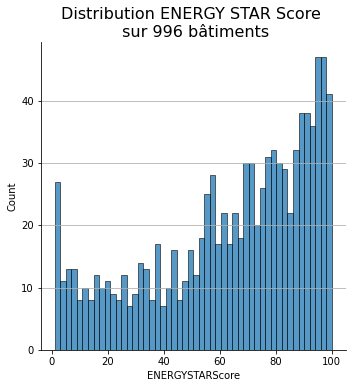

In [100]:
# Représentation graphique de la distribution de ENERGY STAR SCore sur 996 bâtiments
fig=plt.figure(figsize = (20,20))
sns.displot(x=model_3_data['ENERGYSTARScore'],bins=50,)
plt.title('Distribution ENERGY STAR Score \n sur 996 bâtiments', fontsize=16)
plt.grid(axis='y')

**Exportation en fichier.csv du jeu de données nettoyé et issu de la troisième itération**

Les prédictions de la consommation et des emissions sont effectuées dans un notebook séparé ( un notebook par target)

In [101]:
model_3_data.to_csv('2016_Building_Energy_Benchmarking_clean_model_3.csv', index=False)